In [1]:
# -*- coding: utf-8 -*-
"""
⁄©ÿØ ŸÖŸàÿßÿ≤€å DSMC Fokker-Planck ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
==================================================

üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
1. ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
2. ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿµÿ≠€åÿ≠ Diffusion coefficient  
3. ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
4. ‚úÖ A3 (noise amplitude) ÿØŸÇ€åŸÇ
5. ‚úÖ ÿ™ŸÖÿßŸÖ ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 200
PARTICLES_PER_CELL_INIT = 200.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """ÿØÿ±€åÿßŸÅÿ™ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿßÿ≤ ⁄©ÿßÿ±ÿ®ÿ±"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\nüñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:")
    print(f"   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: {available_cores}")
    print(f"   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\nüöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿ®ÿß€åÿØ ÿ≠ÿØÿßŸÇŸÑ 1 ÿ®ÿßÿ¥ÿØ.")
                continue
                
            if workers > max_recommended:
                print(f"‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÜÿ®ÿß€åÿØ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ {max_recommended} ÿ®ÿßÿ¥ÿØ.")
                continue
            
            return workers
                
        except ValueError:
            print("‚ùå ŸÑÿ∑ŸÅÿßŸã €å⁄© ÿπÿØÿØ ÿµÿ≠€åÿ≠ Ÿàÿßÿ±ÿØ ⁄©ŸÜ€åÿØ.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ SORT - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿ≠ÿØÿßŸÇŸÑ ÿßŸÜÿ±⁄ò€å ÿ≠ÿ±ÿßÿ±ÿ™€å
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Qpg ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds ÿ®ÿ±ÿß€å Ÿæÿß€åÿØÿßÿ±€å ÿπÿØÿØ€å
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ≥ÿßÿÆÿ™ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ MODCOEFF ŸÅÿ±ÿ™ÿ±ŸÜ - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖÿπÿßÿØŸÑÿßÿ™ - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # ÿ™ÿµÿ≠€åÿ≠ thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ‚úÖ ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ‚úÖ ÿ™ÿµÿ≠€åÿ≠: pc_c ÿ®ÿß€åÿØ ÿ®ÿ±ÿßÿ®ÿ± PGLAM ÿ®ÿßÿ¥ÿØ ŸÜŸá ÿµŸÅÿ±!
    pc_c = pglam  # ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ FP ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±ÿß€åÿ® ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Diffusion coefficient ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar ÿ®ÿ±ÿß€å Ÿáÿ± ÿ∞ÿ±Ÿá
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # ÿ™ŸàŸÑ€åÿØ ÿ™ÿµÿßÿØŸÅ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ‚úÖ ÿ™ÿµÿ≠€åÿ≠ ÿ≠ŸÅÿ∏ ÿßŸÜÿ±⁄ò€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # ÿ®ÿ±ÿ±ÿ≥€å bounds ÿ≥ÿ±ÿπÿ™
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ÿ™ÿ≠ŸàŸÑ FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ €å⁄© ÿ≥ŸÑŸàŸÑ ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ≥ÿ±ÿπÿ™ ÿ≥ŸÑŸàŸÑ
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß Ÿà ŸÅÿ¥ÿßÿ±
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ÿ≥ÿßÿÆÿ™ Ÿà ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá g_force ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß€å ÿ™ÿ≠ŸàŸÑ
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ ÿ®ÿß ÿ∂ÿ±ÿß€åÿ® ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ŸÑŸàŸÑ {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(particles, cell_indices, dt, fnum, cell_vol, max_workers=None):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™
    """
    if max_workers is None:
        max_workers = MAX_WORKERS
    
    # ÿ™Ÿá€åŸá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    # ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ÿØÿ±ÿ®ÿßÿ±Ÿá ŸÖŸàÿßÿ≤€å‚Äåÿ≥ÿßÿ≤€å
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (max_workers > 1 and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    if use_parallel:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å
        with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
            future_to_cell = {
                executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
                for cell_data in cell_data_list
            }
            
            # ÿ¨ŸÖÿπ‚Äåÿ¢Ÿàÿ±€å ŸÜÿ™ÿß€åÿ¨
            for future in concurrent.futures.as_completed(future_to_cell):
                try:
                    cell_index, updated_particles, n_evolved, efrac = future.result()
                    
                    # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ∞ÿ±ÿßÿ™ ÿØÿ± ÿ¢ÿ±ÿß€åŸá ÿßÿµŸÑ€å
                    indices_in_cell = np.where(cell_indices == cell_index)[0]
                    if len(indices_in_cell) == len(updated_particles):
                        particles[indices_in_cell] = updated_particles
                    
                    total_evolved += n_evolved
                    if efrac != 1.0:
                        total_efrac_sum += efrac
                        efrac_count += 1
                        
                except Exception as e:
                    print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ŸÜÿ™€åÿ¨Ÿá worker: {e}")
    else:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """üöÄ ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá"""
    print(f"\nüöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP")
    print(f"üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print(f"   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)")
    print(f"   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print(f"   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print(f"   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠")
    print(f"üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: {MAX_WORKERS} workers ÿßÿ≤ {os.cpu_count()} Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ")
    
    # ŸÖŸÇÿØÿßÿ±ÿØŸá€å ÿßŸàŸÑ€åŸá ÿ∞ÿ±ÿßÿ™
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨
    time_history = []
    temperature_history = []
    efrac_history = []
    
    start_time = time.time()
    
    print(f"ÿßÿ¨ÿ±ÿß€å {num_steps} ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...")
    
    for step in range(1, num_steps + 1):
        step_start_time = time.time()
        
        # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
        particles[:, 0] += particles[:, 1] * DT
        particles[:, 0] %= LX
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
        
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™
        step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
            particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL, MAX_WORKERS
        )
        
        # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
        total_evolved_particles += step_evolved
        if step_efrac_count > 0:
            total_efrac_sum += step_efrac_sum / step_efrac_count
            efrac_count += 1
        
        step_time = time.time() - step_start_time
        
        # ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å
        if step % SAMPLING_INTERVAL == 0:
            current_time = step * DT
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß
            v_squared = np.sum(particles[:, 1:4]**2, axis=1)
            current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
            
            time_history.append(current_time * 1e9)
            temperature_history.append(current_temp)
            
            avg_efrac = total_efrac_sum / max(efrac_count, 1)
            efrac_history.append(avg_efrac)
            
            if step % (num_steps // 10) == 0:
                progress = step / num_steps * 100
                print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                      f"ÿØŸÖÿß: {current_temp:.1f}K - "
                      f"efrac: {avg_efrac:.6f} - "
                      f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n‚úÖ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
    print(f"ÿ≤ŸÖÿßŸÜ ⁄©ŸÑ: {total_time:.2f} ÿ´ÿßŸÜ€åŸá")
    print(f"ÿØŸÖÿß€å ŸÜŸáÿß€å€å: {final_temp:.2f} K")
    print(f"ŸÖ€åÿßŸÜ⁄Ø€åŸÜ efrac: {avg_efrac_final:.6f}")
    
    # ŸÖŸÇÿß€åÿ≥Ÿá ⁄©€åŸÅ€åÿ™
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("üéâ ⁄©€åŸÅ€åÿ™ ÿπÿßŸÑ€å: efrac ‚âà 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("‚úÖ ⁄©€åŸÅ€åÿ™ ÿÆŸàÿ®")
    else:
        print("‚ö† ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ±")
    
    return particles, time_history, temperature_history, efrac_history

if __name__ == "__main__":
    print(f"üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck")
    print("=" * 60)
    print("ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print("‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print("‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print("‚úÖ qn terms ÿµÿ≠€åÿ≠")
    print("‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE")
    print("=" * 60)
    
    try:
        run_corrected_simulation()
        print("\nüéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
        print("üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.")
        
    except KeyboardInterrupt:
        print("\nüëã ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™Ÿàÿ≥ÿ∑ ⁄©ÿßÿ±ÿ®ÿ± ŸÖÿ™ŸàŸÇŸÅ ÿ¥ÿØ.")
    except Exception as e:
        print(f"\n‚ùå ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ŸÜÿßŸÖŸàŸÅŸÇ: {e}")
        print("üí° Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß ÿ±ÿß ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÜ€åÿØ.")


üñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:
   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: 128
   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: 132



üöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-132) [Enter=128]:  60


üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck
ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
‚úÖ qn terms ÿµÿ≠€åÿ≠
‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE

üöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP
üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠
üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: 60 workers ÿßÿ≤ 128 Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ
ÿßÿ¨ÿ±ÿß€å 20000 ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...
⁄ØÿßŸÖ: 2000/20000 (10.0%) - ÿØŸÖÿß: 600.5K - efrac: 0.998582 - ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: 259.6ms

üëã ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™Ÿàÿ≥ÿ∑ ⁄©ÿßÿ±ÿ®ÿ± ŸÖÿ™ŸàŸÇŸÅ ÿ¥ÿØ.


Process ForkProcess-202040:
Process ForkProcess-202054:
Process ForkProcess-202056:
Process ForkProcess-202039:
Process ForkProcess-202057:
Process ForkProcess-202022:
Process ForkProcess-202038:
Process ForkProcess-202035:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/multiprocessing/process.py", line 313, in _boots

In [1]:
# -*- coding: utf-8 -*-
"""
⁄©ÿØ ŸÖŸàÿßÿ≤€å DSMC Fokker-Planck ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
==================================================

üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
1. ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
2. ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿµÿ≠€åÿ≠ Diffusion coefficient  
3. ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
4. ‚úÖ A3 (noise amplitude) ÿØŸÇ€åŸÇ
5. ‚úÖ ÿ™ŸÖÿßŸÖ ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
6. ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 100.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """ÿØÿ±€åÿßŸÅÿ™ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿßÿ≤ ⁄©ÿßÿ±ÿ®ÿ±"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\nüñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:")
    print(f"   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: {available_cores}")
    print(f"   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\nüöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿ®ÿß€åÿØ ÿ≠ÿØÿßŸÇŸÑ 1 ÿ®ÿßÿ¥ÿØ.")
                continue
                
            if workers > max_recommended:
                print(f"‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÜÿ®ÿß€åÿØ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ {max_recommended} ÿ®ÿßÿ¥ÿØ.")
                continue
            
            return workers
                
        except ValueError:
            print("‚ùå ŸÑÿ∑ŸÅÿßŸã €å⁄© ÿπÿØÿØ ÿµÿ≠€åÿ≠ Ÿàÿßÿ±ÿØ ⁄©ŸÜ€åÿØ.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ SORT - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿ≠ÿØÿßŸÇŸÑ ÿßŸÜÿ±⁄ò€å ÿ≠ÿ±ÿßÿ±ÿ™€å
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Qpg ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds ÿ®ÿ±ÿß€å Ÿæÿß€åÿØÿßÿ±€å ÿπÿØÿØ€å
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ≥ÿßÿÆÿ™ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ MODCOEFF ŸÅÿ±ÿ™ÿ±ŸÜ - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖÿπÿßÿØŸÑÿßÿ™ - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # ÿ™ÿµÿ≠€åÿ≠ thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ‚úÖ ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ‚úÖ ÿ™ÿµÿ≠€åÿ≠: pc_c ÿ®ÿß€åÿØ ÿ®ÿ±ÿßÿ®ÿ± PGLAM ÿ®ÿßÿ¥ÿØ ŸÜŸá ÿµŸÅÿ±!
    pc_c = pglam  # ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ FP ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±ÿß€åÿ® ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Diffusion coefficient ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar ÿ®ÿ±ÿß€å Ÿáÿ± ÿ∞ÿ±Ÿá
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # ÿ™ŸàŸÑ€åÿØ ÿ™ÿµÿßÿØŸÅ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ‚úÖ ÿ™ÿµÿ≠€åÿ≠ ÿ≠ŸÅÿ∏ ÿßŸÜÿ±⁄ò€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # ÿ®ÿ±ÿ±ÿ≥€å bounds ÿ≥ÿ±ÿπÿ™
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ÿ™ÿ≠ŸàŸÑ FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ €å⁄© ÿ≥ŸÑŸàŸÑ ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ≥ÿ±ÿπÿ™ ÿ≥ŸÑŸàŸÑ
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß Ÿà ŸÅÿ¥ÿßÿ±
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ÿ≥ÿßÿÆÿ™ Ÿà ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá g_force ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß€å ÿ™ÿ≠ŸàŸÑ
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ ÿ®ÿß ÿ∂ÿ±ÿß€åÿ® ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ŸÑŸàŸÑ {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ - ExecutorPool ÿßÿ≤ ÿ®€åÿ±ŸàŸÜ ÿØÿ±€åÿßŸÅÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ
    """
    # ÿ™Ÿá€åŸá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ÿØÿ±ÿ®ÿßÿ±Ÿá ŸÖŸàÿßÿ≤€å‚Äåÿ≥ÿßÿ≤€å
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å - ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ executor ŸÖŸàÿ¨ŸàÿØ
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # ÿ¨ŸÖÿπ‚Äåÿ¢Ÿàÿ±€å ŸÜÿ™ÿß€åÿ¨
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ∞ÿ±ÿßÿ™ ÿØÿ± ÿ¢ÿ±ÿß€åŸá ÿßÿµŸÑ€å
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ŸÜÿ™€åÿ¨Ÿá worker: {e}")
    else:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """üöÄ ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá - ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ + ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ"""
    print(f"\nüöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP")
    print(f"üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print(f"   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)")
    print(f"   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print(f"   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print(f"   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠")
    print(f"   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print(f"   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization")
    print(f"üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: {MAX_WORKERS} workers ÿßÿ≤ {os.cpu_count()} Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ")
    
    # ŸÖŸÇÿØÿßÿ±ÿØŸá€å ÿßŸàŸÑ€åŸá ÿ∞ÿ±ÿßÿ™
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿß NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ‚úÖ ÿ¢ÿ±ÿß€åŸá ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß: 0=ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™, 1=ÿ≥ÿ±ÿπÿ™ u, 2=ÿ≥ÿ±ÿπÿ™ v, 3=ÿ≥ÿ±ÿπÿ™ w, 4=ÿØŸÖÿß
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"ÿßÿ¨ÿ±ÿß€å {num_steps} ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...")
    
    # ‚úÖ‚úÖ‚úÖ ÿ™ÿ∫€å€åÿ± ⁄©ŸÑ€åÿØ€å: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"üöÄ ÿßÿ≥ÿ™ÿÆÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ®ÿß {MAX_WORKERS} worker ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ‚úÖ‚úÖ‚úÖ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ®ÿß executor ŸÖŸàÿ¨ŸàÿØ (ÿ®ÿØŸàŸÜ ÿß€åÿ¨ÿßÿØ ŸÖÿ¨ÿØÿØ)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ‚úÖ ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß ⁄©ŸÑ€å
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                              f"ÿØŸÖÿß: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    else:
        # ‚úÖ ÿ≠ÿßŸÑÿ™ ÿ≥ÿ±€åÿßŸÑ (MAX_WORKERS = 1)
        print("üîÑ ÿßÿ¨ÿ±ÿß€å ÿ≥ÿ±€åÿßŸÑ (ÿ™⁄©‚ÄåŸáÿ≥ÿ™Ÿá)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                          f"ÿØŸÖÿß: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n‚úÖ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
    print(f"ÿ≤ŸÖÿßŸÜ ⁄©ŸÑ: {total_time:.2f} ÿ´ÿßŸÜ€åŸá")
    print(f"ÿØŸÖÿß€å ŸÜŸáÿß€å€å: {final_temp:.2f} K")
    print(f"ŸÖ€åÿßŸÜ⁄Ø€åŸÜ efrac: {avg_efrac_final:.6f}")
    
    # ŸÖŸÇÿß€åÿ≥Ÿá ⁄©€åŸÅ€åÿ™
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("üéâ ⁄©€åŸÅ€åÿ™ ÿπÿßŸÑ€å: efrac ‚âà 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("‚úÖ ⁄©€åŸÅ€åÿ™ ÿÆŸàÿ®")
    else:
        print("‚ö† ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ±")
    
    # ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ
    print(f"\nüìä ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    analysis_start = time.time()
    
    # ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ®ÿß NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿØÿ± {analysis_time:.2f} ÿ´ÿßŸÜ€åŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ")
    
    return particles, time_history, temperature_history, efrac_history, fast_results

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ®ÿß NumPy vectorization
    """
    print("üîç ÿ™ÿ≠ŸÑ€åŸÑ‚ÄåŸáÿß€å ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    
    results = {}
    
    # 1. ÿ¢ŸÖÿßÿ± ⁄©ŸÑ€å ÿØŸÖÿß
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. ÿ¢ŸÖÿßÿ± efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. ÿ™ÿ≠ŸÑ€åŸÑ ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å (ÿ¢ÿÆÿ±€åŸÜ snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # ÿ¢ÿÆÿ±€åŸÜ ÿ≤ŸÖÿßŸÜ
        
        # ÿ¢ŸÖÿßÿ± ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # ÿ¢ŸÖÿßÿ± ÿØŸÖÿß€å ŸÅÿ∂ÿß€å€å
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. ÿ™ÿ≠ŸÑ€åŸÑ Ÿæÿß€åÿØÿßÿ±€å ÿ≤ŸÖÿßŸÜ€å (ŸÜŸÖŸàŸÜŸá ⁄©ŸÖ)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # ŸÅŸÇÿ∑ 3 ÿ≥ŸÑŸàŸÑ ŸÜŸÖŸàŸÜŸá
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # ÿßÿ≥ÿ™ÿÆÿ±ÿßÿ¨ ÿ≥ÿ±€å ÿ≤ŸÖÿßŸÜ€å
            time_series = history_array[:, sample_cells, var_idx]
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±€åÿ® ÿ™ÿ∫€å€åÿ±ÿßÿ™
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # ŸÜŸÖÿß€åÿ¥ ŸÜÿ™ÿß€åÿ¨
    print(f"\nüìà ŸÜÿ™ÿß€åÿ¨ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ:")
    print(f"   üå°Ô∏è ÿØŸÖÿß: {results['temp_stats']['mean']:.1f}¬±{results['temp_stats']['std']:.1f} K")
    print(f"   ‚ö° efrac: {results['efrac_stats']['mean']:.6f} (ÿßŸÜÿ≠ÿ±ÿßŸÅ: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   üîÑ €å⁄©ŸÜŸàÿßÿÆÿ™€å ŸÅÿ∂ÿß€å€å: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   üìä Ÿæÿß€åÿØÿßÿ±€å ÿØŸÖÿß: {temp_stability:.3f}")
    
    return results

if __name__ == "__main__":
    print(f"üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck")
    print("=" * 60)
    print("ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print("‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print("‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print("‚úÖ qn terms ÿµÿ≠€åÿ≠")
    print("‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE")
    print("‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print("‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ")
    print("=" * 60)
    
    try:
        results = run_corrected_simulation()
        print("\nüéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
        print("üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.")
        print("üöÄ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßÿ≥ÿ™.")
        print("‚ö° ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿß⁄©ŸÜŸàŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ.")
        
    except KeyboardInterrupt:
        print("\nüëã ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™Ÿàÿ≥ÿ∑ ⁄©ÿßÿ±ÿ®ÿ± ŸÖÿ™ŸàŸÇŸÅ ÿ¥ÿØ.")
    except Exception as e:
        print(f"\n‚ùå ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ŸÜÿßŸÖŸàŸÅŸÇ: {e}")
        print("üí° Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß ÿ±ÿß ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÜ€åÿØ.")


üñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:
   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: 128
   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: 132



üöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-132) [Enter=128]:  60


üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck
ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
‚úÖ qn terms ÿµÿ≠€åÿ≠
‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ

üöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP
üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠
   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization
üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: 60 workers ÿßÿ≤ 128 Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ
ÿßÿ¨ÿ±ÿß€å 20000 ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...
üöÄ ÿßÿ≥ÿ™ÿÆÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ®ÿß 60 worker ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ
⁄ØÿßŸÖ: 2000/20000 (10.0%) - ÿØŸÖÿß: 268.3K - efrac: 0.999996 - ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ


üñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:
   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: 128
   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: 132



üöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-132) [Enter=128]:  60


üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck
ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
‚úÖ qn terms ÿµÿ≠€åÿ≠
‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ
‚úÖ ŸÜŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ŸÜÿ™ÿß€åÿ¨: ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß + ÿ¢ŸÖÿßÿ±

üöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP
üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠
   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization
üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: 60 workers ÿßÿ≤ 128 Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ
ÿßÿ¨ÿ±ÿß€å 20000 ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...
üöÄ ÿßÿ≥ÿ™ÿÆÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ®ÿß 60 worker ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ
⁄ØÿßŸÖ: 2000/20

/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_57894/3716543347.py:884: UserWarning: Glyph 128202 (\N{BAR CHART}) missin

‚úÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß ÿ¢ŸÖÿßÿØŸá Ÿáÿ≥ÿ™ŸÜÿØ!


/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans

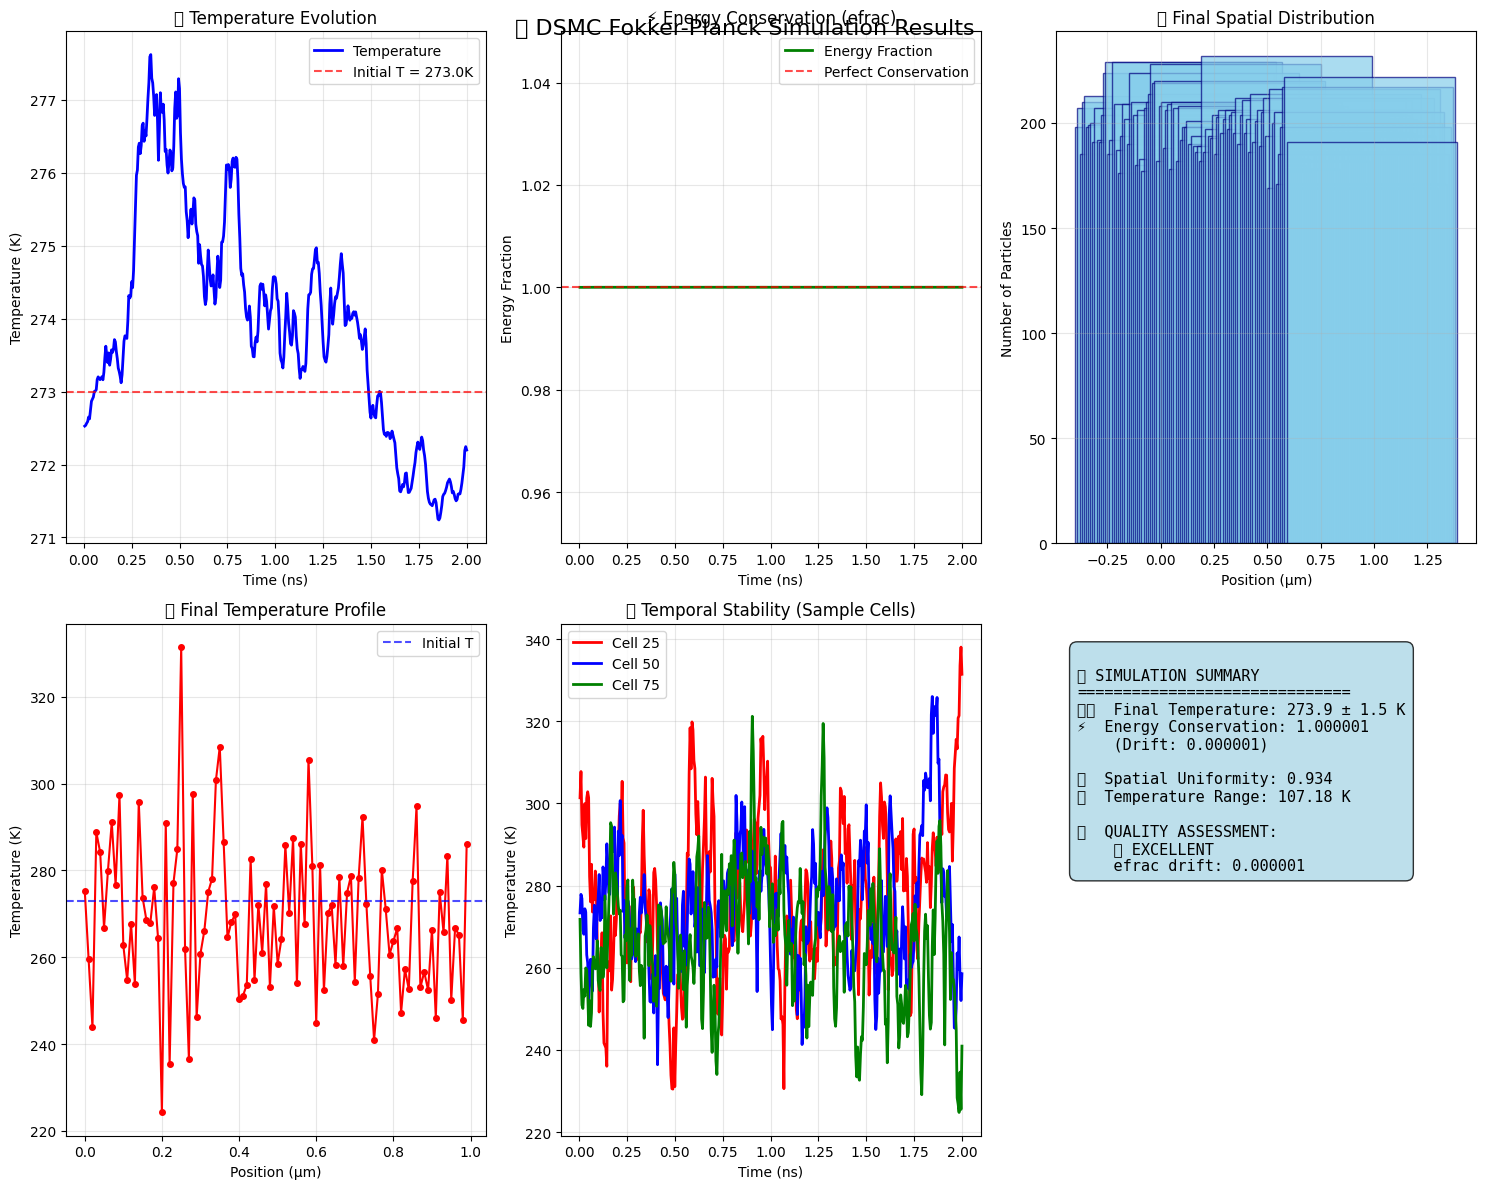

üíæ ŸÜÿ™ÿß€åÿ¨ ÿØÿ± ŸÅÿß€åŸÑ 'dsmc_simulation_results.png' ÿ∞ÿÆ€åÿ±Ÿá ÿ¥ÿØ

üéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!
üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.
üöÄ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßÿ≥ÿ™.
‚ö° ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿß⁄©ŸÜŸàŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ.
üé® ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ⁄©ÿßŸÖŸÑ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸÜÿØ.

üí° ÿ®ÿ±ÿß€å ŸÖÿ¥ÿßŸáÿØŸá ŸÖÿ¨ÿØÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿßÿå ÿßÿ≥⁄©ÿ±€åŸæÿ™ ÿ±ÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ¨ÿ±ÿß ⁄©ŸÜ€åÿØ.


<Figure size 640x480 with 0 Axes>

In [1]:
# -*- coding: utf-8 -*-
"""
⁄©ÿØ ŸÖŸàÿßÿ≤€å DSMC Fokker-Planck ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
==================================================

üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
1. ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
2. ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿµÿ≠€åÿ≠ Diffusion coefficient  
3. ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
4. ‚úÖ A3 (noise amplitude) ÿØŸÇ€åŸÇ
5. ‚úÖ ÿ™ŸÖÿßŸÖ ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
6. ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 200.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """ÿØÿ±€åÿßŸÅÿ™ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿßÿ≤ ⁄©ÿßÿ±ÿ®ÿ±"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\nüñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:")
    print(f"   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: {available_cores}")
    print(f"   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\nüöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿ®ÿß€åÿØ ÿ≠ÿØÿßŸÇŸÑ 1 ÿ®ÿßÿ¥ÿØ.")
                continue
                
            if workers > max_recommended:
                print(f"‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÜÿ®ÿß€åÿØ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ {max_recommended} ÿ®ÿßÿ¥ÿØ.")
                continue
            
            return workers
                
        except ValueError:
            print("‚ùå ŸÑÿ∑ŸÅÿßŸã €å⁄© ÿπÿØÿØ ÿµÿ≠€åÿ≠ Ÿàÿßÿ±ÿØ ⁄©ŸÜ€åÿØ.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ SORT - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿ≠ÿØÿßŸÇŸÑ ÿßŸÜÿ±⁄ò€å ÿ≠ÿ±ÿßÿ±ÿ™€å
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Qpg ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds ÿ®ÿ±ÿß€å Ÿæÿß€åÿØÿßÿ±€å ÿπÿØÿØ€å
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ≥ÿßÿÆÿ™ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ MODCOEFF ŸÅÿ±ÿ™ÿ±ŸÜ - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖÿπÿßÿØŸÑÿßÿ™ - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # ÿ™ÿµÿ≠€åÿ≠ thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ‚úÖ ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ‚úÖ ÿ™ÿµÿ≠€åÿ≠: pc_c ÿ®ÿß€åÿØ ÿ®ÿ±ÿßÿ®ÿ± PGLAM ÿ®ÿßÿ¥ÿØ ŸÜŸá ÿµŸÅÿ±!
    pc_c = pglam  # ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ FP ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±ÿß€åÿ® ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Diffusion coefficient ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar ÿ®ÿ±ÿß€å Ÿáÿ± ÿ∞ÿ±Ÿá
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # ÿ™ŸàŸÑ€åÿØ ÿ™ÿµÿßÿØŸÅ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ‚úÖ ÿ™ÿµÿ≠€åÿ≠ ÿ≠ŸÅÿ∏ ÿßŸÜÿ±⁄ò€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # ÿ®ÿ±ÿ±ÿ≥€å bounds ÿ≥ÿ±ÿπÿ™
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ÿ™ÿ≠ŸàŸÑ FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ €å⁄© ÿ≥ŸÑŸàŸÑ ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ≥ÿ±ÿπÿ™ ÿ≥ŸÑŸàŸÑ
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß Ÿà ŸÅÿ¥ÿßÿ±
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ÿ≥ÿßÿÆÿ™ Ÿà ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá g_force ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß€å ÿ™ÿ≠ŸàŸÑ
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ ÿ®ÿß ÿ∂ÿ±ÿß€åÿ® ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ŸÑŸàŸÑ {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ - ExecutorPool ÿßÿ≤ ÿ®€åÿ±ŸàŸÜ ÿØÿ±€åÿßŸÅÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ
    """
    # ÿ™Ÿá€åŸá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ÿØÿ±ÿ®ÿßÿ±Ÿá ŸÖŸàÿßÿ≤€å‚Äåÿ≥ÿßÿ≤€å
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å - ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ executor ŸÖŸàÿ¨ŸàÿØ
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # ÿ¨ŸÖÿπ‚Äåÿ¢Ÿàÿ±€å ŸÜÿ™ÿß€åÿ¨
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ∞ÿ±ÿßÿ™ ÿØÿ± ÿ¢ÿ±ÿß€åŸá ÿßÿµŸÑ€å
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ŸÜÿ™€åÿ¨Ÿá worker: {e}")
    else:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """üöÄ ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá - ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ + ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ"""
    print(f"\nüöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP")
    print(f"üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print(f"   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)")
    print(f"   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print(f"   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print(f"   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠")
    print(f"   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print(f"   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization")
    print(f"üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: {MAX_WORKERS} workers ÿßÿ≤ {os.cpu_count()} Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ")
    
    # ŸÖŸÇÿØÿßÿ±ÿØŸá€å ÿßŸàŸÑ€åŸá ÿ∞ÿ±ÿßÿ™
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿß NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ‚úÖ ÿ¢ÿ±ÿß€åŸá ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß: 0=ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™, 1=ÿ≥ÿ±ÿπÿ™ u, 2=ÿ≥ÿ±ÿπÿ™ v, 3=ÿ≥ÿ±ÿπÿ™ w, 4=ÿØŸÖÿß
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"ÿßÿ¨ÿ±ÿß€å {num_steps} ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...")
    
    # ‚úÖ‚úÖ‚úÖ ÿ™ÿ∫€å€åÿ± ⁄©ŸÑ€åÿØ€å: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"üöÄ ÿßÿ≥ÿ™ÿÆÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ®ÿß {MAX_WORKERS} worker ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ‚úÖ‚úÖ‚úÖ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ®ÿß executor ŸÖŸàÿ¨ŸàÿØ (ÿ®ÿØŸàŸÜ ÿß€åÿ¨ÿßÿØ ŸÖÿ¨ÿØÿØ)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ‚úÖ ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß ⁄©ŸÑ€å
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                              f"ÿØŸÖÿß: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    else:
        # ‚úÖ ÿ≠ÿßŸÑÿ™ ÿ≥ÿ±€åÿßŸÑ (MAX_WORKERS = 1)
        print("üîÑ ÿßÿ¨ÿ±ÿß€å ÿ≥ÿ±€åÿßŸÑ (ÿ™⁄©‚ÄåŸáÿ≥ÿ™Ÿá)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                          f"ÿØŸÖÿß: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n‚úÖ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
    print(f"ÿ≤ŸÖÿßŸÜ ⁄©ŸÑ: {total_time:.2f} ÿ´ÿßŸÜ€åŸá")
    print(f"ÿØŸÖÿß€å ŸÜŸáÿß€å€å: {final_temp:.2f} K")
    print(f"ŸÖ€åÿßŸÜ⁄Ø€åŸÜ efrac: {avg_efrac_final:.6f}")
    
    # ŸÖŸÇÿß€åÿ≥Ÿá ⁄©€åŸÅ€åÿ™
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("üéâ ⁄©€åŸÅ€åÿ™ ÿπÿßŸÑ€å: efrac ‚âà 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("‚úÖ ⁄©€åŸÅ€åÿ™ ÿÆŸàÿ®")
    else:
        print("‚ö† ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ±")
    
    # ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ
    print(f"\nüìä ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    analysis_start = time.time()
    
    # ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ®ÿß NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿØÿ± {analysis_time:.2f} ÿ´ÿßŸÜ€åŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ")
    
    # ‚úÖ ŸÜŸÖÿß€åÿ¥ ÿ®ÿµÿ±€å ŸÜÿ™ÿß€åÿ¨
    print(f"\nüé® ÿ¢ŸÖÿßÿØŸá‚Äåÿ≥ÿßÿ≤€å ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß...")
    plot_simulation_results(time_history, temperature_history, efrac_history, history_array, fast_results)
    
    return particles, time_history, temperature_history, efrac_history, fast_results

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ®ÿß NumPy vectorization
    """
    print("üîç ÿ™ÿ≠ŸÑ€åŸÑ‚ÄåŸáÿß€å ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    
    results = {}
    
    # 1. ÿ¢ŸÖÿßÿ± ⁄©ŸÑ€å ÿØŸÖÿß
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. ÿ¢ŸÖÿßÿ± efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. ÿ™ÿ≠ŸÑ€åŸÑ ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å (ÿ¢ÿÆÿ±€åŸÜ snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # ÿ¢ÿÆÿ±€åŸÜ ÿ≤ŸÖÿßŸÜ
        
        # ÿ¢ŸÖÿßÿ± ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # ÿ¢ŸÖÿßÿ± ÿØŸÖÿß€å ŸÅÿ∂ÿß€å€å
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. ÿ™ÿ≠ŸÑ€åŸÑ Ÿæÿß€åÿØÿßÿ±€å ÿ≤ŸÖÿßŸÜ€å (ŸÜŸÖŸàŸÜŸá ⁄©ŸÖ)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # ŸÅŸÇÿ∑ 3 ÿ≥ŸÑŸàŸÑ ŸÜŸÖŸàŸÜŸá
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # ÿßÿ≥ÿ™ÿÆÿ±ÿßÿ¨ ÿ≥ÿ±€å ÿ≤ŸÖÿßŸÜ€å
            time_series = history_array[:, sample_cells, var_idx]
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±€åÿ® ÿ™ÿ∫€å€åÿ±ÿßÿ™
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # ŸÜŸÖÿß€åÿ¥ ŸÜÿ™ÿß€åÿ¨
    print(f"\nüìà ŸÜÿ™ÿß€åÿ¨ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ:")
    print(f"   üå°Ô∏è ÿØŸÖÿß: {results['temp_stats']['mean']:.1f}¬±{results['temp_stats']['std']:.1f} K")
    print(f"   ‚ö° efrac: {results['efrac_stats']['mean']:.6f} (ÿßŸÜÿ≠ÿ±ÿßŸÅ: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   üîÑ €å⁄©ŸÜŸàÿßÿÆÿ™€å ŸÅÿ∂ÿß€å€å: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   üìä Ÿæÿß€åÿØÿßÿ±€å ÿØŸÖÿß: {temp_stability:.3f}")
    
    return results

def plot_simulation_results(time_history, temperature_history, efrac_history, history_array, results):
    """
    ‚úÖ ŸÜŸÖÿß€åÿ¥ ÿ®ÿµÿ±€å ŸÜÿ™ÿß€åÿ¨ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    """
    print("\nüé® ÿ±ÿ≥ŸÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ŸÜÿ™ÿß€åÿ¨...")
    
    # ÿ™ŸÜÿ∏€åŸÖÿßÿ™ ŸÜŸÖŸàÿØÿßÿ±
    plt.style.use('default')
    fig = plt.figure(figsize=(15, 12))
    
    # 1. ŸÜŸÖŸàÿØÿßÿ± ÿØŸÖÿß ÿØÿ± ÿ∑ŸàŸÑ ÿ≤ŸÖÿßŸÜ
    plt.subplot(2, 3, 1)
    plt.plot(time_history, temperature_history, 'b-', linewidth=2, label='Temperature')
    plt.axhline(y=T_INIT, color='r', linestyle='--', alpha=0.7, label=f'Initial T = {T_INIT}K')
    plt.xlabel('Time (ns)')
    plt.ylabel('Temperature (K)')
    plt.title('üå°Ô∏è Temperature Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. ŸÜŸÖŸàÿØÿßÿ± efrac ÿØÿ± ÿ∑ŸàŸÑ ÿ≤ŸÖÿßŸÜ
    plt.subplot(2, 3, 2)
    plt.plot(time_history, efrac_history, 'g-', linewidth=2, label='Energy Fraction')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect Conservation')
    plt.xlabel('Time (ns)')
    plt.ylabel('Energy Fraction')
    plt.title('‚ö° Energy Conservation (efrac)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.95, 1.05)
    
    # 3. ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å ŸÜŸáÿß€å€å - ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
    if len(history_array) > 0:
        plt.subplot(2, 3, 3)
        final_particles = history_array[-1, :, 0]  # ÿ¢ÿÆÿ±€åŸÜ snapshotÿå ŸáŸÖŸá ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿßÿå ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
        cell_positions = np.arange(NUM_CELLS_X) * (LX / NUM_CELLS_X) * 1e6  # ÿ®Ÿá ŸÖ€å⁄©ÿ±ŸàŸÖÿ™ÿ±
        plt.bar(cell_positions, final_particles, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.xlabel('Position (Œºm)')
        plt.ylabel('Number of Particles')
        plt.title('üîÑ Final Spatial Distribution')
        plt.grid(True, alpha=0.3)
    
    # 4. ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å ÿØŸÖÿß
    if len(history_array) > 0:
        plt.subplot(2, 3, 4)
        final_temps = history_array[-1, :, 4]  # ÿ¢ÿÆÿ±€åŸÜ snapshotÿå ŸáŸÖŸá ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿßÿå ÿØŸÖÿß
        plt.plot(cell_positions, final_temps, 'ro-', markersize=4, linewidth=1.5)
        plt.axhline(y=T_INIT, color='b', linestyle='--', alpha=0.7, label=f'Initial T')
        plt.xlabel('Position (Œºm)')
        plt.ylabel('Temperature (K)')
        plt.title('üå°Ô∏è Final Temperature Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 5. Ÿæÿß€åÿØÿßÿ±€å ÿ≥€åÿ≥ÿ™ŸÖ (ŸÜŸÖŸàŸÜŸá ÿßÿ≤ ⁄ÜŸÜÿØ ÿ≥ŸÑŸàŸÑ)
    if len(history_array) > 10:
        plt.subplot(2, 3, 5)
        sample_cells = [25, 50, 75]
        colors = ['red', 'blue', 'green']
        for i, cell_idx in enumerate(sample_cells):
            cell_temps = history_array[:, cell_idx, 4]
            plt.plot(time_history, cell_temps, color=colors[i], 
                    linewidth=2, label=f'Cell {cell_idx}')
        plt.xlabel('Time (ns)')
        plt.ylabel('Temperature (K)')
        plt.title('üìä Temporal Stability (Sample Cells)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 6. ÿÆŸÑÿßÿµŸá ÿ¢ŸÖÿßÿ±€å
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # ŸÖÿ™ŸÜ ÿÆŸÑÿßÿµŸá ŸÜÿ™ÿß€åÿ¨
    summary_text = f"""
üìà SIMULATION SUMMARY
{'='*30}
üå°Ô∏è  Final Temperature: {results['temp_stats']['mean']:.1f} ¬± {results['temp_stats']['std']:.1f} K
‚ö°  Energy Conservation: {results['efrac_stats']['mean']:.6f}
    (Drift: {results['efrac_stats']['drift']:.6f})

üìä  Spatial Uniformity: {results.get('spatial_stats', {}).get('uniformity', 0):.3f}
üîÑ  Temperature Range: {results.get('spatial_temp', {}).get('range', 0):.2f} K

‚úÖ  QUALITY ASSESSMENT:
"""
    
    # ÿßÿ±ÿ≤€åÿßÿ®€å ⁄©€åŸÅ€åÿ™
    efrac_drift = results['efrac_stats']['drift']
    if efrac_drift < 0.01:
        quality = "üéâ EXCELLENT"
    elif efrac_drift < 0.05:
        quality = "‚úÖ GOOD"
    else:
        quality = "‚ö†Ô∏è  NEEDS REVIEW"
    
    summary_text += f"    {quality}\n"
    summary_text += f"    efrac drift: {efrac_drift:.6f}"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('üöÄ DSMC Fokker-Planck Simulation Results', fontsize=16, y=0.98)
    
    print("‚úÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß ÿ¢ŸÖÿßÿØŸá Ÿáÿ≥ÿ™ŸÜÿØ!")
    plt.show()
    
    # ÿ∞ÿÆ€åÿ±Ÿá ŸÅÿß€åŸÑ (ÿßÿÆÿ™€åÿßÿ±€å)
    try:
        plt.savefig('dsmc_simulation_results.png', dpi=300, bbox_inches='tight')
        print("üíæ ŸÜÿ™ÿß€åÿ¨ ÿØÿ± ŸÅÿß€åŸÑ 'dsmc_simulation_results.png' ÿ∞ÿÆ€åÿ±Ÿá ÿ¥ÿØ")
    except:
        print("‚ö†Ô∏è ÿÆÿ∑ÿß ÿØÿ± ÿ∞ÿÆ€åÿ±Ÿá ŸÅÿß€åŸÑ (ŸÜŸÖŸàÿØÿßÿ± ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸá)")

if __name__ == "__main__":
    print(f"üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck")
    print("=" * 60)
    print("ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print("‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print("‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print("‚úÖ qn terms ÿµÿ≠€åÿ≠")
    print("‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE")
    print("‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print("‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ")
    print("‚úÖ ŸÜŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ŸÜÿ™ÿß€åÿ¨: ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß + ÿ¢ŸÖÿßÿ±")
    print("=" * 60)
    
    try:
        # ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
        simulation_results = run_corrected_simulation()
        
        print("\nüéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
        print("üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.")
        print("üöÄ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßÿ≥ÿ™.")
        print("‚ö° ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿß⁄©ŸÜŸàŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ.")
        print("üé® ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ⁄©ÿßŸÖŸÑ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸÜÿØ.")
        print("\nüí° ÿ®ÿ±ÿß€å ŸÖÿ¥ÿßŸáÿØŸá ŸÖÿ¨ÿØÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿßÿå ÿßÿ≥⁄©ÿ±€åŸæÿ™ ÿ±ÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ¨ÿ±ÿß ⁄©ŸÜ€åÿØ.")
        
    except KeyboardInterrupt:
        print("\nüëã ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™Ÿàÿ≥ÿ∑ ⁄©ÿßÿ±ÿ®ÿ± ŸÖÿ™ŸàŸÇŸÅ ÿ¥ÿØ.")
    except Exception as e:
        print(f"\n‚ùå ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ŸÜÿßŸÖŸàŸÅŸÇ: {e}")
        print("üí° Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß ÿ±ÿß ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÜ€åÿØ.")
        import traceback
        traceback.print_exc()


üñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:
   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: 128
   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: 132



üöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-132) [Enter=128]:  60


üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck
ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
‚úÖ qn terms ÿµÿ≠€åÿ≠
‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ
‚úÖ ŸÜŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ŸÜÿ™ÿß€åÿ¨: ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß + ÿ¢ŸÖÿßÿ±
‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann: ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ + ÿ™ÿπÿßÿØŸÑ ÿ≠ÿ±ÿßÿ±ÿ™€å

üöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP
üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠
   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization
   ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ⁄©ÿßŸÖŸÑ
üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: 60 workers ÿßÿ≤ 128 Ÿáÿ≥ÿ™Ÿá

/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_62638/907410436.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu

‚úÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß ÿ¢ŸÖÿßÿØŸá Ÿáÿ≥ÿ™ŸÜÿØ!
üéØ Maxwell-Boltzmann ÿ™ÿ≠ŸÑ€åŸÑ ÿ¥ÿØ: ÿÆÿ∑ÿß€å ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ≥ÿ±ÿπÿ™ = 0.07%


/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu 

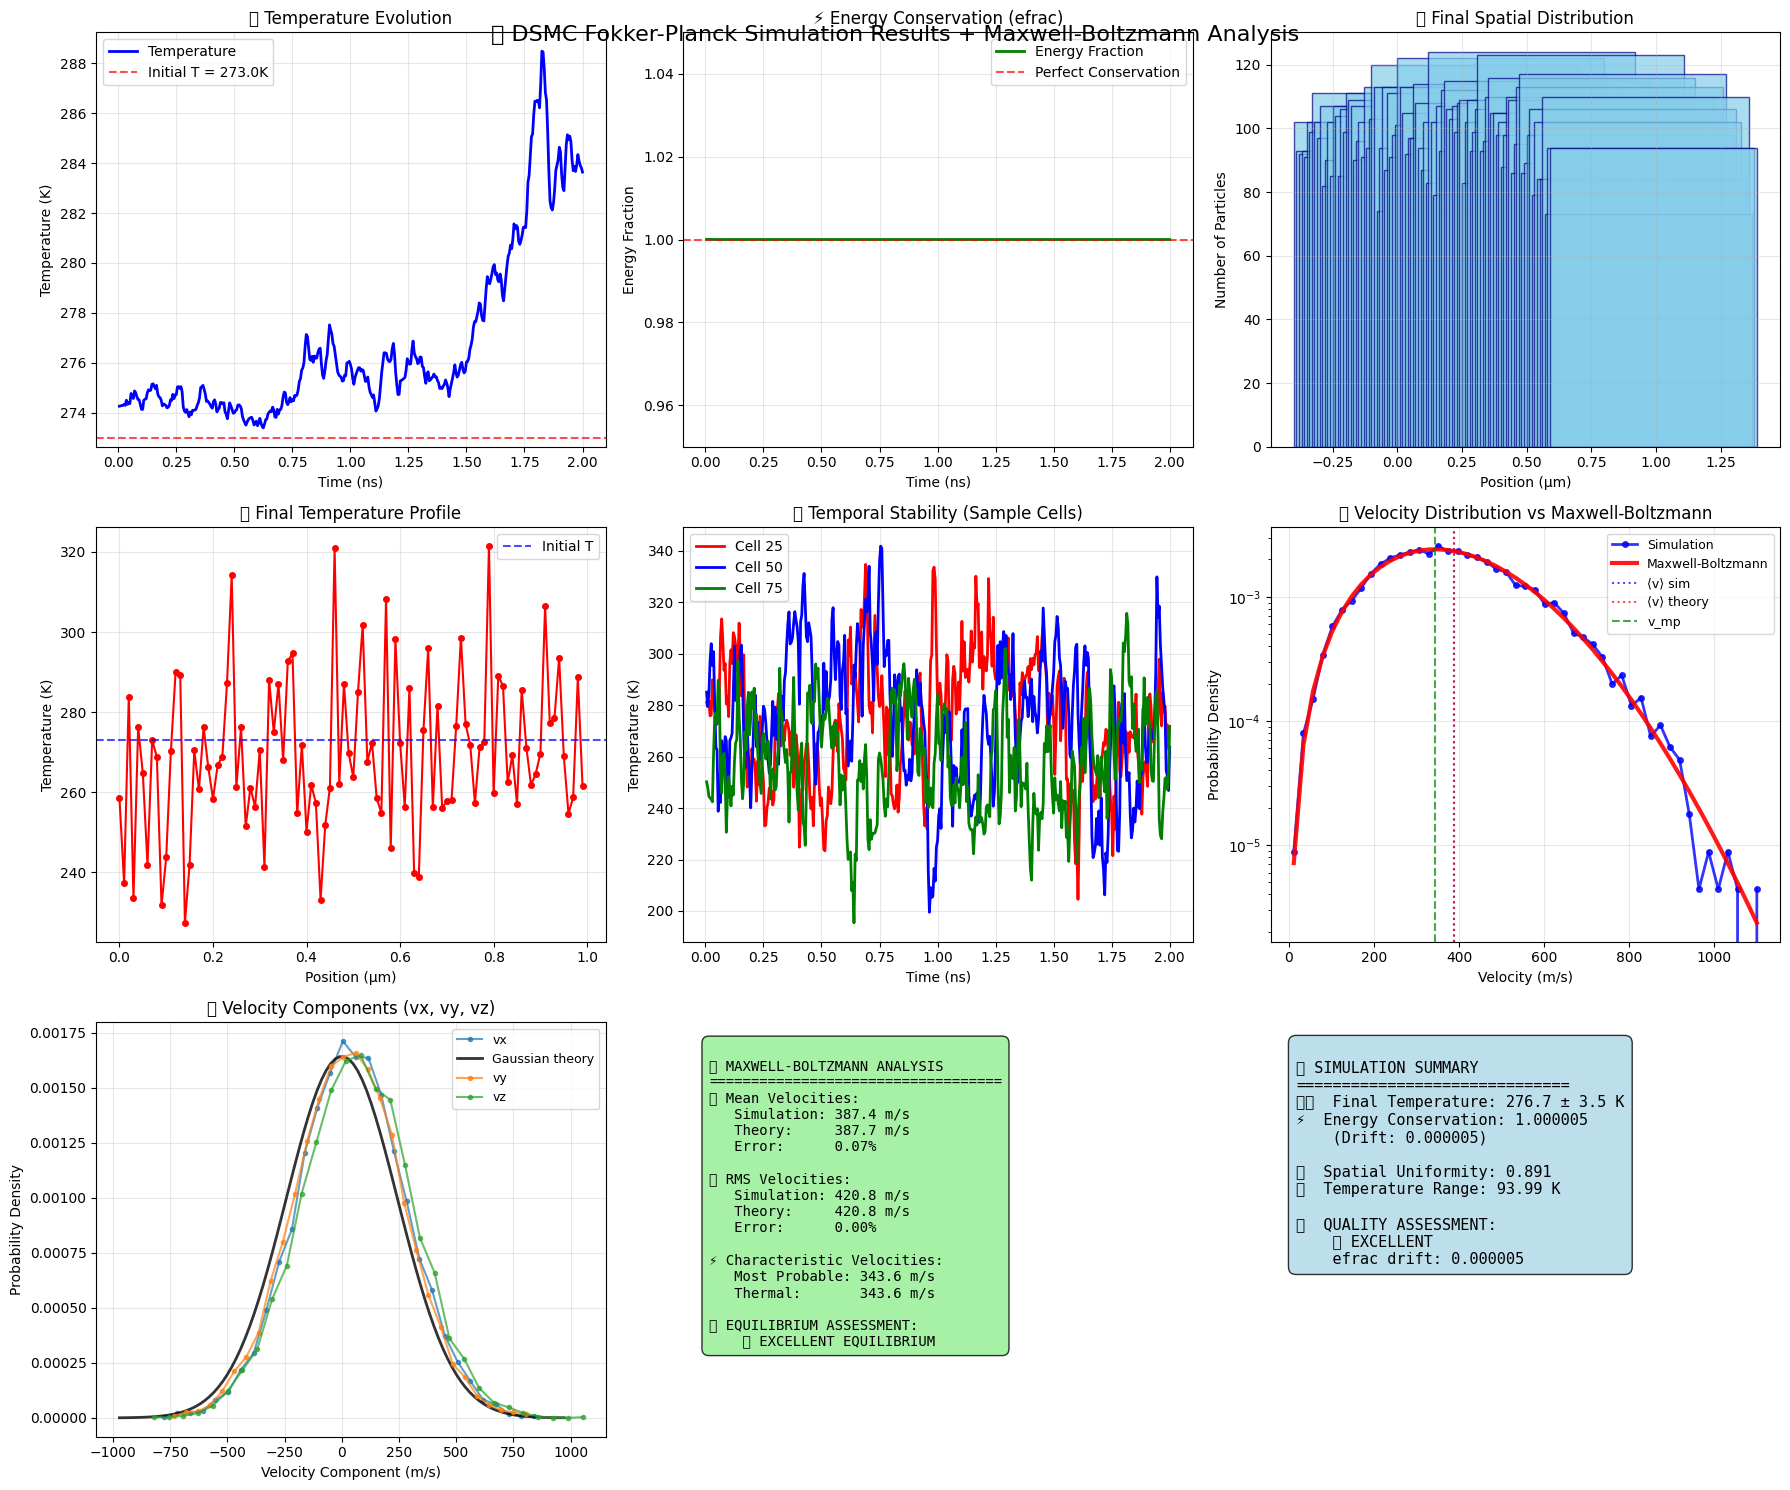

üíæ ŸÜÿ™ÿß€åÿ¨ ⁄©ÿßŸÖŸÑ ÿØÿ± ŸÅÿß€åŸÑ 'dsmc_simulation_results_complete.png' ÿ∞ÿÆ€åÿ±Ÿá ÿ¥ÿØ

üéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!
üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.
üöÄ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßÿ≥ÿ™.
‚ö° ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿß⁄©ŸÜŸàŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ.
üé® ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ⁄©ÿßŸÖŸÑ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸÜÿØ.
üéØ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ.

üí° ÿ®ÿ±ÿß€å ŸÖÿ¥ÿßŸáÿØŸá ŸÖÿ¨ÿØÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿßÿå ÿßÿ≥⁄©ÿ±€åŸæÿ™ ÿ±ÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ¨ÿ±ÿß ⁄©ŸÜ€åÿØ.


<Figure size 640x480 with 0 Axes>

In [1]:
# -*- coding: utf-8 -*-
"""
⁄©ÿØ ŸÖŸàÿßÿ≤€å DSMC Fokker-Planck ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
==================================================

üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
1. ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
2. ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿµÿ≠€åÿ≠ Diffusion coefficient  
3. ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
4. ‚úÖ A3 (noise amplitude) ÿØŸÇ€åŸÇ
5. ‚úÖ ÿ™ŸÖÿßŸÖ ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
6. ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 100.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-9
SAMPLING_INTERVAL = 50

# Parallel parameters
def get_user_workers():
    """ÿØÿ±€åÿßŸÅÿ™ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿßÿ≤ ⁄©ÿßÿ±ÿ®ÿ±"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\nüñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:")
    print(f"   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: {available_cores}")
    print(f"   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\nüöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿ®ÿß€åÿØ ÿ≠ÿØÿßŸÇŸÑ 1 ÿ®ÿßÿ¥ÿØ.")
                continue
                
            if workers > max_recommended:
                print(f"‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÜÿ®ÿß€åÿØ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ {max_recommended} ÿ®ÿßÿ¥ÿØ.")
                continue
            
            return workers
                
        except ValueError:
            print("‚ùå ŸÑÿ∑ŸÅÿßŸã €å⁄© ÿπÿØÿØ ÿµÿ≠€åÿ≠ Ÿàÿßÿ±ÿØ ⁄©ŸÜ€åÿØ.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ SORT - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿ≠ÿØÿßŸÇŸÑ ÿßŸÜÿ±⁄ò€å ÿ≠ÿ±ÿßÿ±ÿ™€å
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Qpg ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds ÿ®ÿ±ÿß€å Ÿæÿß€åÿØÿßÿ±€å ÿπÿØÿØ€å
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ≥ÿßÿÆÿ™ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ MODCOEFF ŸÅÿ±ÿ™ÿ±ŸÜ - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖÿπÿßÿØŸÑÿßÿ™ - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # ÿ™ÿµÿ≠€åÿ≠ thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ‚úÖ ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ‚úÖ ÿ™ÿµÿ≠€åÿ≠: pc_c ÿ®ÿß€åÿØ ÿ®ÿ±ÿßÿ®ÿ± PGLAM ÿ®ÿßÿ¥ÿØ ŸÜŸá ÿµŸÅÿ±!
    pc_c = pglam  # ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ FP ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±ÿß€åÿ® ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Diffusion coefficient ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar ÿ®ÿ±ÿß€å Ÿáÿ± ÿ∞ÿ±Ÿá
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # ÿ™ŸàŸÑ€åÿØ ÿ™ÿµÿßÿØŸÅ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ‚úÖ ÿ™ÿµÿ≠€åÿ≠ ÿ≠ŸÅÿ∏ ÿßŸÜÿ±⁄ò€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # ÿ®ÿ±ÿ±ÿ≥€å bounds ÿ≥ÿ±ÿπÿ™
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ÿ™ÿ≠ŸàŸÑ FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ €å⁄© ÿ≥ŸÑŸàŸÑ ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ≥ÿ±ÿπÿ™ ÿ≥ŸÑŸàŸÑ
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß Ÿà ŸÅÿ¥ÿßÿ±
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ÿ≥ÿßÿÆÿ™ Ÿà ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá g_force ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß€å ÿ™ÿ≠ŸàŸÑ
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ ÿ®ÿß ÿ∂ÿ±ÿß€åÿ® ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ŸÑŸàŸÑ {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ - ExecutorPool ÿßÿ≤ ÿ®€åÿ±ŸàŸÜ ÿØÿ±€åÿßŸÅÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ
    """
    # ÿ™Ÿá€åŸá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ÿØÿ±ÿ®ÿßÿ±Ÿá ŸÖŸàÿßÿ≤€å‚Äåÿ≥ÿßÿ≤€å
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å - ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ executor ŸÖŸàÿ¨ŸàÿØ
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # ÿ¨ŸÖÿπ‚Äåÿ¢Ÿàÿ±€å ŸÜÿ™ÿß€åÿ¨
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ∞ÿ±ÿßÿ™ ÿØÿ± ÿ¢ÿ±ÿß€åŸá ÿßÿµŸÑ€å
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ŸÜÿ™€åÿ¨Ÿá worker: {e}")
    else:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """üöÄ ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá - ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ + ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ"""
    print(f"\nüöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP")
    print(f"üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print(f"   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)")
    print(f"   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print(f"   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print(f"   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠")
    print(f"   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print(f"   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization")
    print(f"   ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ⁄©ÿßŸÖŸÑ")
    print(f"üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: {MAX_WORKERS} workers ÿßÿ≤ {os.cpu_count()} Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ")
    
    # ŸÖŸÇÿØÿßÿ±ÿØŸá€å ÿßŸàŸÑ€åŸá ÿ∞ÿ±ÿßÿ™
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿß NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ‚úÖ ÿ¢ÿ±ÿß€åŸá ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß: 0=ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™, 1=ÿ≥ÿ±ÿπÿ™ u, 2=ÿ≥ÿ±ÿπÿ™ v, 3=ÿ≥ÿ±ÿπÿ™ w, 4=ÿØŸÖÿß
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"ÿßÿ¨ÿ±ÿß€å {num_steps} ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...")
    
    # ‚úÖ‚úÖ‚úÖ ÿ™ÿ∫€å€åÿ± ⁄©ŸÑ€åÿØ€å: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"üöÄ ÿßÿ≥ÿ™ÿÆÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ®ÿß {MAX_WORKERS} worker ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ‚úÖ‚úÖ‚úÖ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ®ÿß executor ŸÖŸàÿ¨ŸàÿØ (ÿ®ÿØŸàŸÜ ÿß€åÿ¨ÿßÿØ ŸÖÿ¨ÿØÿØ)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ‚úÖ ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß ⁄©ŸÑ€å
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                              f"ÿØŸÖÿß: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    else:
        # ‚úÖ ÿ≠ÿßŸÑÿ™ ÿ≥ÿ±€åÿßŸÑ (MAX_WORKERS = 1)
        print("üîÑ ÿßÿ¨ÿ±ÿß€å ÿ≥ÿ±€åÿßŸÑ (ÿ™⁄©‚ÄåŸáÿ≥ÿ™Ÿá)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                          f"ÿØŸÖÿß: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n‚úÖ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
    print(f"ÿ≤ŸÖÿßŸÜ ⁄©ŸÑ: {total_time:.2f} ÿ´ÿßŸÜ€åŸá")
    print(f"ÿØŸÖÿß€å ŸÜŸáÿß€å€å: {final_temp:.2f} K")
    print(f"ŸÖ€åÿßŸÜ⁄Ø€åŸÜ efrac: {avg_efrac_final:.6f}")
    
    # ŸÖŸÇÿß€åÿ≥Ÿá ⁄©€åŸÅ€åÿ™
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("üéâ ⁄©€åŸÅ€åÿ™ ÿπÿßŸÑ€å: efrac ‚âà 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("‚úÖ ⁄©€åŸÅ€åÿ™ ÿÆŸàÿ®")
    else:
        print("‚ö† ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ±")
    
    # ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ
    print(f"\nüìä ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    analysis_start = time.time()
    
    # ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ®ÿß NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿØÿ± {analysis_time:.2f} ÿ´ÿßŸÜ€åŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ")
    
    # ‚úÖ ŸÜŸÖÿß€åÿ¥ ÿ®ÿµÿ±€å ŸÜÿ™ÿß€åÿ¨
    print(f"\nüé® ÿ¢ŸÖÿßÿØŸá‚Äåÿ≥ÿßÿ≤€å ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß...")
    velocity_analysis = plot_simulation_results(time_history, temperature_history, efrac_history, history_array, fast_results, particles)
    
    return particles, time_history, temperature_history, efrac_history, fast_results, velocity_analysis

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ®ÿß NumPy vectorization
    """
    print("üîç ÿ™ÿ≠ŸÑ€åŸÑ‚ÄåŸáÿß€å ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    
    results = {}
    
    # 1. ÿ¢ŸÖÿßÿ± ⁄©ŸÑ€å ÿØŸÖÿß
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. ÿ¢ŸÖÿßÿ± efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. ÿ™ÿ≠ŸÑ€åŸÑ ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å (ÿ¢ÿÆÿ±€åŸÜ snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # ÿ¢ÿÆÿ±€åŸÜ ÿ≤ŸÖÿßŸÜ
        
        # ÿ¢ŸÖÿßÿ± ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # ÿ¢ŸÖÿßÿ± ÿØŸÖÿß€å ŸÅÿ∂ÿß€å€å
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. ÿ™ÿ≠ŸÑ€åŸÑ Ÿæÿß€åÿØÿßÿ±€å ÿ≤ŸÖÿßŸÜ€å (ŸÜŸÖŸàŸÜŸá ⁄©ŸÖ)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # ŸÅŸÇÿ∑ 3 ÿ≥ŸÑŸàŸÑ ŸÜŸÖŸàŸÜŸá
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # ÿßÿ≥ÿ™ÿÆÿ±ÿßÿ¨ ÿ≥ÿ±€å ÿ≤ŸÖÿßŸÜ€å
            time_series = history_array[:, sample_cells, var_idx]
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±€åÿ® ÿ™ÿ∫€å€åÿ±ÿßÿ™
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # ŸÜŸÖÿß€åÿ¥ ŸÜÿ™ÿß€åÿ¨
    print(f"\nüìà ŸÜÿ™ÿß€åÿ¨ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ:")
    print(f"   üå°Ô∏è ÿØŸÖÿß: {results['temp_stats']['mean']:.1f}¬±{results['temp_stats']['std']:.1f} K")
    print(f"   ‚ö° efrac: {results['efrac_stats']['mean']:.6f} (ÿßŸÜÿ≠ÿ±ÿßŸÅ: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   üîÑ €å⁄©ŸÜŸàÿßÿÆÿ™€å ŸÅÿ∂ÿß€å€å: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   üìä Ÿæÿß€åÿØÿßÿ±€å ÿØŸÖÿß: {temp_stability:.3f}")
    
    return results

def analyze_velocity_distribution(particles, temperature):
    """
    ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ Ÿà ŸÖŸÇÿß€åÿ≥Ÿá ÿ®ÿß Maxwell-Boltzmann
    """
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ®ÿ≤ÿ±⁄Ø€å ÿ≥ÿ±ÿπÿ™ ÿ∞ÿ±ÿßÿ™
    velocities = particles[:, 1:4]
    v_magnitudes = np.linalg.norm(velocities, axis=1)
    
    # Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß€å Maxwell-Boltzmann
    v_thermal = np.sqrt(2 * KB * temperature / MASS_AR)
    
    # ÿ¢ŸÖÿßÿØŸá‚Äåÿ≥ÿßÿ≤€å ÿØÿßÿØŸá‚ÄåŸáÿß ÿ®ÿ±ÿß€å Ÿá€åÿ≥ÿ™Ÿà⁄Øÿ±ÿßŸÖ
    v_max = min(np.max(v_magnitudes), 5 * v_thermal)  # ŸÖÿ≠ÿØŸàÿØ ⁄©ÿ±ÿØŸÜ ÿ®ÿ±ÿß€å ŸÜŸÖÿß€åÿ¥ ÿ®Ÿáÿ™ÿ±
    v_bins = np.linspace(0, v_max, 50)
    v_centers = (v_bins[:-1] + v_bins[1:]) / 2
    
    # Ÿá€åÿ≥ÿ™Ÿà⁄Øÿ±ÿßŸÖ ÿ≥ÿ±ÿπÿ™ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    counts, _ = np.histogram(v_magnitudes, bins=v_bins, density=True)
    
    # ÿ™Ÿàÿ≤€åÿπ Maxwell-Boltzmann ÿ™ÿ¶Ÿàÿ±€å
    # f(v) = 4œÄ * (m/(2œÄkT))^(3/2) * v¬≤ * exp(-mv¬≤/(2kT))
    mb_prefactor = 4 * np.pi * (MASS_AR / (2 * np.pi * KB * temperature))**(3/2)
    mb_theoretical = mb_prefactor * v_centers**2 * np.exp(-MASS_AR * v_centers**2 / (2 * KB * temperature))
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ¢ŸÖÿßÿ± ŸÖŸÇÿß€åÿ≥Ÿá
    # ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ≥ÿ±ÿπÿ™ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å vs ÿ™ÿ¶Ÿàÿ±€å
    v_mean_sim = np.mean(v_magnitudes)
    v_mean_theory = np.sqrt(8 * KB * temperature / (np.pi * MASS_AR))
    
    # ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß€å ŸÖÿ¥ÿÆÿµŸá
    v_most_probable_theory = np.sqrt(2 * KB * temperature / MASS_AR)
    v_rms_theory = np.sqrt(3 * KB * temperature / MASS_AR)
    v_rms_sim = np.sqrt(np.mean(v_magnitudes**2))
    
    return {
        'v_centers': v_centers,
        'counts_sim': counts,
        'mb_theoretical': mb_theoretical,
        'v_mean_sim': v_mean_sim,
        'v_mean_theory': v_mean_theory,
        'v_most_probable': v_most_probable_theory,
        'v_rms_sim': v_rms_sim,
        'v_rms_theory': v_rms_theory,
        'v_thermal': v_thermal
    }

def plot_simulation_results(time_history, temperature_history, efrac_history, history_array, results, particles):
    """
    ‚úÖ ŸÜŸÖÿß€åÿ¥ ÿ®ÿµÿ±€å ŸÜÿ™ÿß€åÿ¨ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å + ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ Maxwell-Boltzmann
    """
    print("\nüé® ÿ±ÿ≥ŸÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ŸÜÿ™ÿß€åÿ¨...")
    
    # ÿ™ŸÜÿ∏€åŸÖÿßÿ™ ŸÜŸÖŸàÿØÿßÿ±
    plt.style.use('default')
    fig = plt.figure(figsize=(18, 15))  # ÿßŸÜÿØÿßÿ≤Ÿá ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ™ÿ± ÿ®ÿ±ÿß€å ŸÜŸÖŸàÿØÿßÿ± ÿßÿ∂ÿßŸÅ€å
    
    # 1. ŸÜŸÖŸàÿØÿßÿ± ÿØŸÖÿß ÿØÿ± ÿ∑ŸàŸÑ ÿ≤ŸÖÿßŸÜ
    plt.subplot(3, 3, 1)
    plt.plot(time_history, temperature_history, 'b-', linewidth=2, label='Temperature')
    plt.axhline(y=T_INIT, color='r', linestyle='--', alpha=0.7, label=f'Initial T = {T_INIT}K')
    plt.xlabel('Time (ns)')
    plt.ylabel('Temperature (K)')
    plt.title('üå°Ô∏è Temperature Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. ŸÜŸÖŸàÿØÿßÿ± efrac ÿØÿ± ÿ∑ŸàŸÑ ÿ≤ŸÖÿßŸÜ
    plt.subplot(3, 3, 2)
    plt.plot(time_history, efrac_history, 'g-', linewidth=2, label='Energy Fraction')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect Conservation')
    plt.xlabel('Time (ns)')
    plt.ylabel('Energy Fraction')
    plt.title('‚ö° Energy Conservation (efrac)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.95, 1.05)
    
    # 3. ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å ŸÜŸáÿß€å€å - ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
    if len(history_array) > 0:
        plt.subplot(3, 3, 3)
        final_particles = history_array[-1, :, 0]  # ÿ¢ÿÆÿ±€åŸÜ snapshotÿå ŸáŸÖŸá ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿßÿå ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
        cell_positions = np.arange(NUM_CELLS_X) * (LX / NUM_CELLS_X) * 1e6  # ÿ®Ÿá ŸÖ€å⁄©ÿ±ŸàŸÖÿ™ÿ±
        plt.bar(cell_positions, final_particles, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.xlabel('Position (Œºm)')
        plt.ylabel('Number of Particles')
        plt.title('üîÑ Final Spatial Distribution')
        plt.grid(True, alpha=0.3)
    
    # 4. ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å ÿØŸÖÿß
    if len(history_array) > 0:
        plt.subplot(3, 3, 4)
        final_temps = history_array[-1, :, 4]  # ÿ¢ÿÆÿ±€åŸÜ snapshotÿå ŸáŸÖŸá ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿßÿå ÿØŸÖÿß
        plt.plot(cell_positions, final_temps, 'ro-', markersize=4, linewidth=1.5)
        plt.axhline(y=T_INIT, color='b', linestyle='--', alpha=0.7, label=f'Initial T')
        plt.xlabel('Position (Œºm)')
        plt.ylabel('Temperature (K)')
        plt.title('üå°Ô∏è Final Temperature Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 5. Ÿæÿß€åÿØÿßÿ±€å ÿ≥€åÿ≥ÿ™ŸÖ (ŸÜŸÖŸàŸÜŸá ÿßÿ≤ ⁄ÜŸÜÿØ ÿ≥ŸÑŸàŸÑ)
    if len(history_array) > 10:
        plt.subplot(3, 3, 5)
        sample_cells = [25, 50, 75]
        colors = ['red', 'blue', 'green']
        for i, cell_idx in enumerate(sample_cells):
            cell_temps = history_array[:, cell_idx, 4]
            plt.plot(time_history, cell_temps, color=colors[i], 
                    linewidth=2, label=f'Cell {cell_idx}')
        plt.xlabel('Time (ns)')
        plt.ylabel('Temperature (K)')
        plt.title('üìä Temporal Stability (Sample Cells)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 6. ‚úÖ ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ Maxwell-Boltzmann
    plt.subplot(3, 3, 6)
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    vel_analysis = analyze_velocity_distribution(particles, final_temp)
    
    plt.plot(vel_analysis['v_centers'], vel_analysis['counts_sim'], 'bo-', 
             markersize=4, linewidth=2, label='Simulation', alpha=0.8)
    plt.plot(vel_analysis['v_centers'], vel_analysis['mb_theoretical'], 'r-', 
             linewidth=3, label='Maxwell-Boltzmann', alpha=0.9)
    
    # ÿÆÿ∑Ÿàÿ∑ ŸÖÿ¥ÿÆÿµŸá
    plt.axvline(vel_analysis['v_mean_sim'], color='blue', linestyle=':', alpha=0.7, label='‚ü®v‚ü© sim')
    plt.axvline(vel_analysis['v_mean_theory'], color='red', linestyle=':', alpha=0.7, label='‚ü®v‚ü© theory')
    plt.axvline(vel_analysis['v_most_probable'], color='green', linestyle='--', alpha=0.7, label='v_mp')
    
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Probability Density')
    plt.title('üéØ Velocity Distribution vs Maxwell-Boltzmann')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å ÿ®ÿ±ÿß€å ŸÜŸÖÿß€åÿ¥ ÿ®Ÿáÿ™ÿ±
    
    # 7. ŸÜŸÖŸàÿØÿßÿ± ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß€å ŸÖÿ§ŸÑŸÅŸá‚Äåÿß€å (vx, vy, vz)
    plt.subplot(3, 3, 7)
    for i, component in enumerate(['vx', 'vy', 'vz']):
        v_component = particles[:, 1+i]
        v_std_theory = np.sqrt(KB * final_temp / MASS_AR)
        
        # Ÿá€åÿ≥ÿ™Ÿà⁄Øÿ±ÿßŸÖ ŸÖÿ§ŸÑŸÅŸá ÿ≥ÿ±ÿπÿ™
        counts, bins = np.histogram(v_component, bins=30, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        plt.plot(bin_centers, counts, 'o-', markersize=3, alpha=0.7, label=f'{component}')
        
        # ÿ™Ÿàÿ≤€åÿπ ⁄ØÿßŸàÿ≥€å ÿ™ÿ¶Ÿàÿ±€å
        v_range = np.linspace(-4*v_std_theory, 4*v_std_theory, 100)
        gaussian_theory = (1/np.sqrt(2*np.pi*v_std_theory**2)) * np.exp(-v_range**2/(2*v_std_theory**2))
        if i == 0:  # ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿÆÿ∑ ÿ™ÿ¶Ÿàÿ±€å
            plt.plot(v_range, gaussian_theory, 'k-', linewidth=2, alpha=0.8, label='Gaussian theory')
    
    plt.xlabel('Velocity Component (m/s)')
    plt.ylabel('Probability Density')
    plt.title('üìà Velocity Components (vx, vy, vz)')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    # 8. ÿÆŸÑÿßÿµŸá ÿ¢ŸÖÿßÿ±€å ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™
    plt.subplot(3, 3, 8)
    plt.axis('off')
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿÆÿ∑ÿß€å ŸÜÿ≥ÿ®€å
    v_mean_error = abs(vel_analysis['v_mean_sim'] - vel_analysis['v_mean_theory']) / vel_analysis['v_mean_theory'] * 100
    v_rms_error = abs(vel_analysis['v_rms_sim'] - vel_analysis['v_rms_theory']) / vel_analysis['v_rms_theory'] * 100
    
    mb_summary_text = f"""
üéØ MAXWELL-BOLTZMANN ANALYSIS
{'='*35}
üìä Mean Velocities:
   Simulation: {vel_analysis['v_mean_sim']:.1f} m/s
   Theory:     {vel_analysis['v_mean_theory']:.1f} m/s
   Error:      {v_mean_error:.2f}%

üî• RMS Velocities:
   Simulation: {vel_analysis['v_rms_sim']:.1f} m/s  
   Theory:     {vel_analysis['v_rms_theory']:.1f} m/s
   Error:      {v_rms_error:.2f}%

‚ö° Characteristic Velocities:
   Most Probable: {vel_analysis['v_most_probable']:.1f} m/s
   Thermal:       {vel_analysis['v_thermal']:.1f} m/s

‚úÖ EQUILIBRIUM ASSESSMENT:
"""
    
    # ÿßÿ±ÿ≤€åÿßÿ®€å ÿ™ÿπÿßÿØŸÑ ÿ≠ÿ±ÿßÿ±ÿ™€å
    if v_mean_error < 2.0 and v_rms_error < 2.0:
        equilibrium_status = "üéâ EXCELLENT EQUILIBRIUM"
    elif v_mean_error < 5.0 and v_rms_error < 5.0:
        equilibrium_status = "‚úÖ GOOD EQUILIBRIUM"
    else:
        equilibrium_status = "‚ö†Ô∏è  NEEDS MORE TIME"
    
    mb_summary_text += f"    {equilibrium_status}"
    
    plt.text(0.05, 0.95, mb_summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # 9. ÿÆŸÑÿßÿµŸá ⁄©ŸÑ€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # ŸÖÿ™ŸÜ ÿÆŸÑÿßÿµŸá ŸÜÿ™ÿß€åÿ¨
    summary_text = f"""
üìà SIMULATION SUMMARY
{'='*30}
üå°Ô∏è  Final Temperature: {results['temp_stats']['mean']:.1f} ¬± {results['temp_stats']['std']:.1f} K
‚ö°  Energy Conservation: {results['efrac_stats']['mean']:.6f}
    (Drift: {results['efrac_stats']['drift']:.6f})

üìä  Spatial Uniformity: {results.get('spatial_stats', {}).get('uniformity', 0):.3f}
üîÑ  Temperature Range: {results.get('spatial_temp', {}).get('range', 0):.2f} K

‚úÖ  QUALITY ASSESSMENT:
"""
    
    # ÿßÿ±ÿ≤€åÿßÿ®€å ⁄©€åŸÅ€åÿ™
    efrac_drift = results['efrac_stats']['drift']
    if efrac_drift < 0.01:
        quality = "üéâ EXCELLENT"
    elif efrac_drift < 0.05:
        quality = "‚úÖ GOOD"
    else:
        quality = "‚ö†Ô∏è  NEEDS REVIEW"
    
    summary_text += f"    {quality}\n"
    summary_text += f"    efrac drift: {efrac_drift:.6f}"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('üöÄ DSMC Fokker-Planck Simulation Results + Maxwell-Boltzmann Analysis', fontsize=16, y=0.98)
    
    print("‚úÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß ÿ¢ŸÖÿßÿØŸá Ÿáÿ≥ÿ™ŸÜÿØ!")
    print(f"üéØ Maxwell-Boltzmann ÿ™ÿ≠ŸÑ€åŸÑ ÿ¥ÿØ: ÿÆÿ∑ÿß€å ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ≥ÿ±ÿπÿ™ = {v_mean_error:.2f}%")
    plt.show()
    
    # ÿ∞ÿÆ€åÿ±Ÿá ŸÅÿß€åŸÑ (ÿßÿÆÿ™€åÿßÿ±€å)
    try:
        plt.savefig('dsmc_simulation_results_complete.png', dpi=300, bbox_inches='tight')
        print("üíæ ŸÜÿ™ÿß€åÿ¨ ⁄©ÿßŸÖŸÑ ÿØÿ± ŸÅÿß€åŸÑ 'dsmc_simulation_results_complete.png' ÿ∞ÿÆ€åÿ±Ÿá ÿ¥ÿØ")
    except:
        print("‚ö†Ô∏è ÿÆÿ∑ÿß ÿØÿ± ÿ∞ÿÆ€åÿ±Ÿá ŸÅÿß€åŸÑ (ŸÜŸÖŸàÿØÿßÿ± ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸá)")
        
    return vel_analysis

if __name__ == "__main__":
    print(f"üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck")
    print("=" * 60)
    print("ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print("‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print("‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print("‚úÖ qn terms ÿµÿ≠€åÿ≠")
    print("‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE")
    print("‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print("‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ")
    print("‚úÖ ŸÜŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ŸÜÿ™ÿß€åÿ¨: ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß + ÿ¢ŸÖÿßÿ±")
    print("‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann: ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ + ÿ™ÿπÿßÿØŸÑ ÿ≠ÿ±ÿßÿ±ÿ™€å")
    print("=" * 60)
    
    try:
        # ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
        simulation_results = run_corrected_simulation()
        
        print("\nüéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
        print("üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.")
        print("üöÄ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßÿ≥ÿ™.")
        print("‚ö° ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿß⁄©ŸÜŸàŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ.")
        print("üé® ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ⁄©ÿßŸÖŸÑ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸÜÿØ.")
        print("üéØ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ.")
        print("\nüí° ÿ®ÿ±ÿß€å ŸÖÿ¥ÿßŸáÿØŸá ŸÖÿ¨ÿØÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿßÿå ÿßÿ≥⁄©ÿ±€åŸæÿ™ ÿ±ÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ¨ÿ±ÿß ⁄©ŸÜ€åÿØ.")
        
    except KeyboardInterrupt:
        print("\nüëã ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™Ÿàÿ≥ÿ∑ ⁄©ÿßÿ±ÿ®ÿ± ŸÖÿ™ŸàŸÇŸÅ ÿ¥ÿØ.")
    except Exception as e:
        print(f"\n‚ùå ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ŸÜÿßŸÖŸàŸÅŸÇ: {e}")
        print("üí° Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß ÿ±ÿß ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÜ€åÿØ.")
        import traceback
        traceback.print_exc()


üñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:
   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: 128
   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: 132



üöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-132) [Enter=128]:  60


üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck
ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
‚úÖ qn terms ÿµÿ≠€åÿ≠
‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ
‚úÖ ŸÜŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ŸÜÿ™ÿß€åÿ¨: ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß + ÿ¢ŸÖÿßÿ±
‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann: ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ + ÿ™ÿπÿßÿØŸÑ ÿ≠ÿ±ÿßÿ±ÿ™€å

üöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP
üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ
   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠
   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ
   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization
   ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ⁄©ÿßŸÖŸÑ
üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: 60 workers ÿßÿ≤ 128 Ÿáÿ≥ÿ™Ÿá

/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_62638/2409461109.py:1019: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s)

‚úÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß ÿ¢ŸÖÿßÿØŸá Ÿáÿ≥ÿ™ŸÜÿØ!
üéØ Maxwell-Boltzmann ÿ™ÿ≠ŸÑ€åŸÑ ÿ¥ÿØ: ÿÆÿ∑ÿß€å ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ≥ÿ±ÿπÿ™ = 1.67%


/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/modules/opt/linux-ubuntu24.04-x86_64/jupyterlab/unity-jupyterlab4.4.3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu 

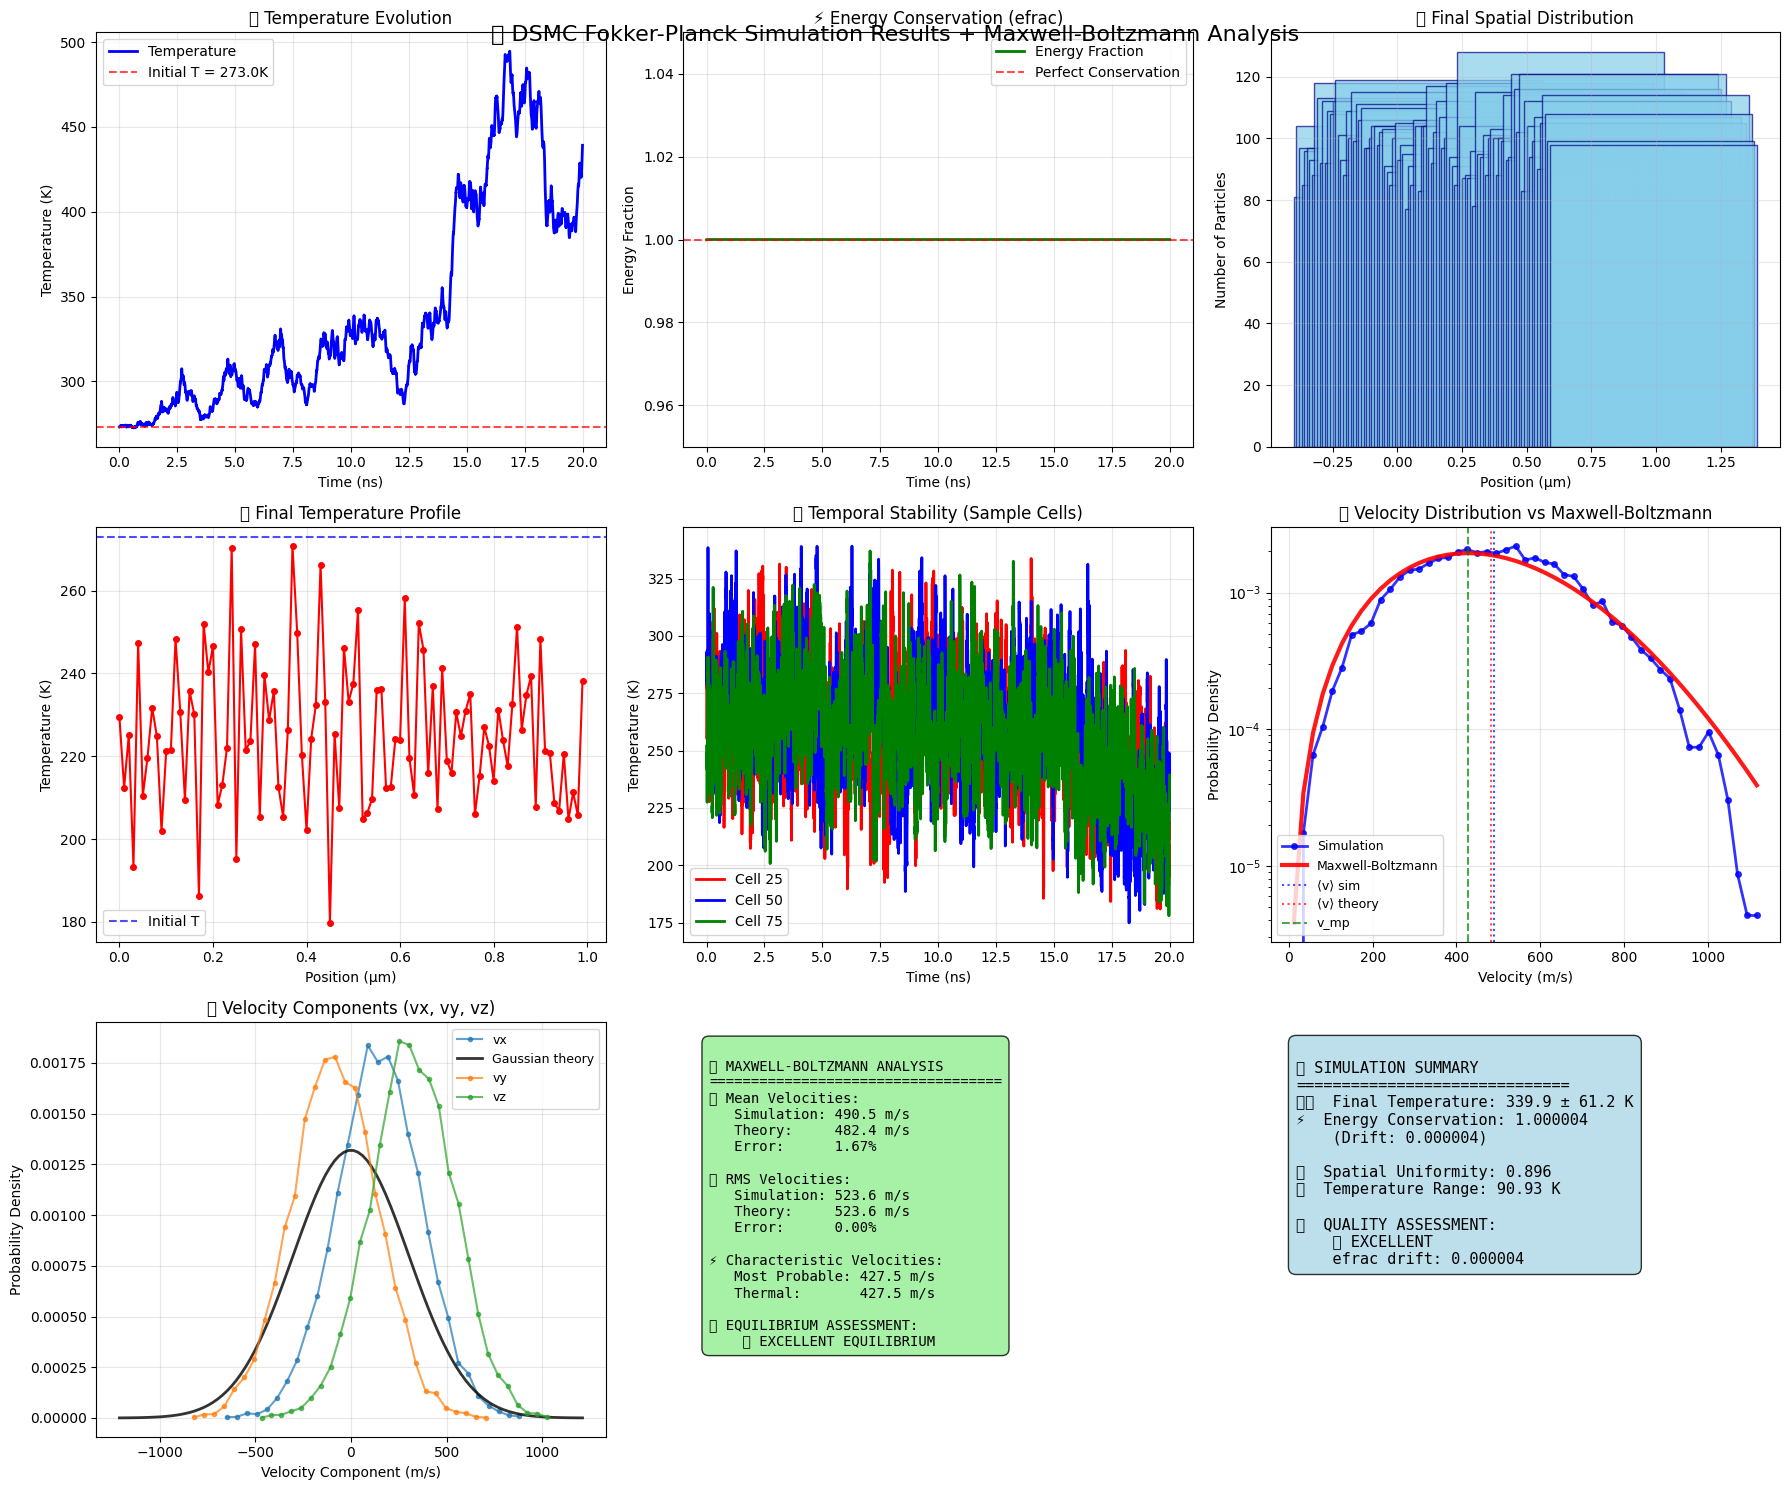

üíæ ŸÜÿ™ÿß€åÿ¨ ⁄©ÿßŸÖŸÑ ÿØÿ± ŸÅÿß€åŸÑ 'dsmc_simulation_results_complete.png' ÿ∞ÿÆ€åÿ±Ÿá ÿ¥ÿØ

üéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!
üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.
üöÄ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßÿ≥ÿ™.
‚ö° ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿß⁄©ŸÜŸàŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ.
üé® ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ⁄©ÿßŸÖŸÑ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸÜÿØ.
üéØ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ.

üí° ÿ®ÿ±ÿß€å ŸÖÿ¥ÿßŸáÿØŸá ŸÖÿ¨ÿØÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿßÿå ÿßÿ≥⁄©ÿ±€åŸæÿ™ ÿ±ÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ¨ÿ±ÿß ⁄©ŸÜ€åÿØ.


<Figure size 640x480 with 0 Axes>

In [2]:
# -*- coding: utf-8 -*-
"""
⁄©ÿØ ŸÖŸàÿßÿ≤€å DSMC Fokker-Planck ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
==================================================

üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:
1. ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)
2. ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿµÿ≠€åÿ≠ Diffusion coefficient  
3. ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
4. ‚úÖ A3 (noise amplitude) ÿØŸÇ€åŸÇ
5. ‚úÖ ÿ™ŸÖÿßŸÖ ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE
6. ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, LinAlgError, svd
import time
import concurrent.futures
import multiprocessing as mp
from functools import partial
import os

# Physical constants
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.50
PI = 3.141592654

# Simulation parameters
LX = 1.0e-6
RHO_INIT = 1.78
T_INIT = 273.0
NUM_CELLS_X = 100
PARTICLES_PER_CELL_INIT = 100.0
N_DENSITY_REAL = RHO_INIT / MASS_AR

# Derived parameters
CELL_VOLUME_CONCEPTUAL = LX / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
TOTAL_PARTICLES_SIM = int(NUM_CELLS_X * PARTICLES_PER_CELL_INIT)
DT = 1.0e-13
TOTAL_TIME = 2.0e-8
SAMPLING_INTERVAL = 25

# Parallel parameters
def get_user_workers():
    """ÿØÿ±€åÿßŸÅÿ™ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿßÿ≤ ⁄©ÿßÿ±ÿ®ÿ±"""
    available_cores = os.cpu_count() or 1
    max_recommended = max(32, available_cores + 4)
    
    print(f"\nüñ•Ô∏è  ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ≥€åÿ≥ÿ™ŸÖ:")
    print(f"   ‚Ä¢ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÅ€åÿ≤€å⁄©€å: {available_cores}")
    print(f"   ‚Ä¢ ÿ≠ÿØÿß⁄©ÿ´ÿ± ÿ™Ÿàÿµ€åŸá ÿ¥ÿØŸá: {max_recommended}")
    
    while True:
        try:
            user_input = input(f"\nüöÄ ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß€å ŸÖŸàÿ±ÿØ ÿßÿ≥ÿ™ŸÅÿßÿØŸá (1-{max_recommended}) [Enter={available_cores}]: ").strip()
            
            if user_input == "":
                return available_cores
            
            workers = int(user_input)
            
            if workers < 1:
                print("‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ÿ®ÿß€åÿØ ÿ≠ÿØÿßŸÇŸÑ 1 ÿ®ÿßÿ¥ÿØ.")
                continue
                
            if workers > max_recommended:
                print(f"‚ùå ÿ™ÿπÿØÿßÿØ Ÿáÿ≥ÿ™Ÿá‚ÄåŸáÿß ŸÜÿ®ÿß€åÿØ ÿ®€åÿ¥ÿ™ÿ± ÿßÿ≤ {max_recommended} ÿ®ÿßÿ¥ÿØ.")
                continue
            
            return workers
                
        except ValueError:
            print("‚ùå ŸÑÿ∑ŸÅÿßŸã €å⁄© ÿπÿØÿØ ÿµÿ≠€åÿ≠ Ÿàÿßÿ±ÿØ ⁄©ŸÜ€åÿØ.")
        except KeyboardInterrupt:
            return available_cores

MAX_WORKERS = get_user_workers()
MIN_PARTICLES_FOR_PARALLEL = 5
CHUNK_SIZE = max(1, NUM_CELLS_X // (MAX_WORKERS * 2))

def calculate_corrected_cell_moments(particles_cell, cell_velocity):
    """
    ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ SORT - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    n_particles = len(particles_cell)
    if n_particles == 0:
        return None
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
    peculiar_vels = particles_cell[:, 1:4] - cell_velocity
    
    # ÿßÿ∑ŸÖ€åŸÜÿßŸÜ ÿßÿ≤ ÿ≠ÿØÿßŸÇŸÑ ÿßŸÜÿ±⁄ò€å ÿ≠ÿ±ÿßÿ±ÿ™€å
    thermal_vel = np.sqrt(KB * T_INIT / MASS_AR)
    min_thermal_energy = (thermal_vel * 0.01)**2
    engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    if np.max(engy_sq) < min_thermal_energy:
        thermal_noise = np.random.normal(0, thermal_vel * 0.01, peculiar_vels.shape)
        peculiar_vels += thermal_noise
        engy_sq = np.sum(peculiar_vels**2, axis=1)
    
    moments = {}
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PIJpg (6 components) - vectorized
    u, v, w = peculiar_vels[:, 0], peculiar_vels[:, 1], peculiar_vels[:, 2]
    moments['PIJpg'] = np.array([
        np.mean(u * u),    # uu
        np.mean(u * v),    # uv
        np.mean(u * w),    # uw
        np.mean(v * v),    # vv
        np.mean(v * w),    # vw
        np.mean(w * w)     # ww
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM3 (10 components) - vectorized
    moments['PGM3'] = np.array([
        np.mean(u**3),         # uuu
        np.mean(u**2 * v),     # uuv
        np.mean(u**2 * w),     # uuw
        np.mean(u * v**2),     # uvv
        np.mean(u * v * w),    # uvw
        np.mean(u * w**2),     # uww
        np.mean(v**3),         # vvv
        np.mean(v**2 * w),     # vvw
        np.mean(v * w**2),     # vww
        np.mean(w**3)          # www
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM4 (6 components) - vectorized
    moments['PGM4'] = np.array([
        np.mean(u * u * engy_sq),
        np.mean(u * v * engy_sq),
        np.mean(u * w * engy_sq),
        np.mean(v * v * engy_sq),
        np.mean(v * w * engy_sq),
        np.mean(w * w * engy_sq)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGM5 (3 components) - vectorized
    engy_quad = engy_sq**2
    moments['PGM5'] = np.array([
        np.mean(u * engy_quad),
        np.mean(v * engy_quad),
        np.mean(w * engy_quad)
    ])
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Qpg ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
    moments['Qpg'] = np.array([
        moments['PGM3'][0] + moments['PGM3'][3] + moments['PGM3'][5],  # Qpg(1)
        moments['PGM3'][1] + moments['PGM3'][6] + moments['PGM3'][8],  # Qpg(2)
        moments['PGM3'][2] + moments['PGM3'][7] + moments['PGM3'][9]   # Qpg(3)
    ])
    
    moments['DM2pg'] = np.mean(engy_sq)
    moments['DPGM4'] = moments['PGM4'][0] + moments['PGM4'][3] + moments['PGM4'][5]
    
    # bounds ÿ®ÿ±ÿß€å Ÿæÿß€åÿØÿßÿ±€å ÿπÿØÿØ€å
    min_second_moment = min_thermal_energy * 0.1
    moments['PIJpg'][0] = max(moments['PIJpg'][0], min_second_moment)
    moments['PIJpg'][3] = max(moments['PIJpg'][3], min_second_moment)
    moments['PIJpg'][5] = max(moments['PIJpg'][5], min_second_moment)
    moments['DM2pg'] = max(moments['DM2pg'], 3 * KB * T_INIT / MASS_AR * 0.1)
    
    return moments

def build_corrected_9x9_fp_system(moments, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ≥ÿßÿÆÿ™ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿØŸÇ€åŸÇÿßŸã ÿ∑ÿ®ŸÇ MODCOEFF ŸÅÿ±ÿ™ÿ±ŸÜ - ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
    """
    PIJpg = moments['PIJpg']
    PGM3 = moments['PGM3']
    PGM4 = moments['PGM4']
    PGM5 = moments['PGM5']
    Qpg = moments['Qpg']
    DM2pg = moments['DM2pg']
    DPGM4 = moments['DPGM4']
    
    collision_freq = pressure / viscosity * 0.5
    pressure_over_visc = pressure / viscosity
    
    # Pre-allocate arrays
    pmatlhs = np.zeros((9, 9))
    pmatrhs = np.zeros(9)
    
    # ****************** for cij and pij (vectorized where possible)
    pmatlhs[0, 0:3] = 2.0 * PIJpg[0:3]
    
    pmatlhs[1, :] = [PIJpg[1], PIJpg[0] + PIJpg[3], PIJpg[4], PIJpg[1], PIJpg[2], 0, 0, 0, 0]
    pmatlhs[2, :] = [PIJpg[2], PIJpg[4], PIJpg[0] + PIJpg[5], 0, PIJpg[1], PIJpg[2], 0, 0, 0]
    
    pmatlhs[3, 1] = 2.0 * PIJpg[1]
    pmatlhs[3, 3:5] = 2.0 * PIJpg[3:5]
    
    pmatlhs[4, :] = [0, PIJpg[2], PIJpg[1], PIJpg[4], PIJpg[3] + PIJpg[5], PIJpg[4], 0, 0, 0]
    
    pmatlhs[5, 2] = 2.0 * PIJpg[2]
    pmatlhs[5, 4:6] = 2.0 * PIJpg[4:6]
    
    # *********************** for gammatr and pij 
    pmatlhs[0, 6] = 2.0 * Qpg[0]
    pmatlhs[1, 6:8] = [Qpg[1], Qpg[0]]
    pmatlhs[2, [6, 8]] = [Qpg[2], Qpg[0]]
    pmatlhs[3, 7] = 2.0 * Qpg[1]
    pmatlhs[4, 7:9] = [Qpg[2], Qpg[1]]
    pmatlhs[5, 8] = 2.0 * Qpg[2]
    
    # ******************** for cij and qtr
    pmatlhs[6, :6] = [Qpg[0] + 2.0 * PGM3[0], Qpg[1] + 4.0 * PGM3[1], Qpg[2] + 4.0 * PGM3[2],
                      2.0 * PGM3[3], 4.0 * PGM3[4], 2.0 * PGM3[5]]
    
    pmatlhs[7, :6] = [2.0 * PGM3[1], Qpg[0] + 4.0 * PGM3[3], 4.0 * PGM3[4],
                      Qpg[1] + 2.0 * PGM3[6], Qpg[2] + 4.0 * PGM3[7], 2.0 * PGM3[8]]
    
    pmatlhs[8, :6] = [2.0 * PGM3[2], 4.0 * PGM3[4], Qpg[0] + 4.0 * PGM3[5],
                      2.0 * PGM3[7], Qpg[1] + 4.0 * PGM3[8], Qpg[2] + 2.0 * PGM3[9]]
    
    # ************************* for gammatr and qtr
    diag_term = DPGM4 - DM2pg**2
    pmatlhs[6, 6:9] = [diag_term + 2.0 * PGM4[0] - 2.0 * DM2pg * PIJpg[0],
                       2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2]]
    
    pmatlhs[7, 6:9] = [2.0 * PGM4[1] - 2.0 * DM2pg * PIJpg[1],
                       diag_term + 2.0 * PGM4[3] - 2.0 * DM2pg * PIJpg[3],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4]]
    
    pmatlhs[8, 6:9] = [2.0 * PGM4[2] - 2.0 * DM2pg * PIJpg[2],
                       2.0 * PGM4[4] - 2.0 * DM2pg * PIJpg[4],
                       diag_term + 2.0 * PGM4[5] - 2.0 * DM2pg * PIJpg[5]]
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá PGLAM
    pglam_terms = ((PIJpg[0] - DM2pg/3.0)**2 + 2.0*PIJpg[1]**2 + 2.0*PIJpg[2]**2 +
                   (PIJpg[3] - DM2pg/3.0)**2 + 2.0*PIJpg[4]**2 + (PIJpg[5] - DM2pg/3.0)**2)
    pglam = -pglam_terms * collision_freq / (DM2pg**3.5)
    
    # ÿ≥ŸÖÿ™ ÿ±ÿßÿ≥ÿ™ ŸÖÿπÿßÿØŸÑÿßÿ™ - vectorized
    pmatrhs[0:6] = pglam * (-2.0 * PGM4[0:6])
    
    pmatrhs[6] = -pglam * (3.0 * PGM5[0] - DM2pg * Qpg[0] - 
                           2.0 * (PIJpg[0]*Qpg[0] + PIJpg[1]*Qpg[1] + PIJpg[2]*Qpg[2]))
    pmatrhs[7] = -pglam * (3.0 * PGM5[1] - DM2pg * Qpg[1] - 
                           2.0 * (PIJpg[1]*Qpg[0] + PIJpg[3]*Qpg[1] + PIJpg[4]*Qpg[2]))
    pmatrhs[8] = -pglam * (3.0 * PGM5[2] - DM2pg * Qpg[2] - 
                           2.0 * (PIJpg[2]*Qpg[0] + PIJpg[4]*Qpg[1] + PIJpg[5]*Qpg[2]))
    
    # ÿ™ÿµÿ≠€åÿ≠ thermal_coeff
    thermal_coeff = 3.0 * collision_freq - (2.0/3.0) * pressure_over_visc
    pmatrhs[6:9] += thermal_coeff * Qpg[0:3]
    
    return pmatlhs, pmatrhs, pglam

def solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam):
    """
    ‚úÖ ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9 ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ pc_c = PGLAM
    """
    try:
        rcond = np.linalg.cond(pmatlhs)
        
        if rcond < 1e12:
            solution = solve(pmatlhs, pmatrhs)
            method_used = 'direct_solve'
        else:
            U, s, Vt = svd(pmatlhs, full_matrices=False)
            s_inv = np.where(s > 1e-12 * s[0], 1.0/s, 0.0)
            solution = Vt.T @ np.diag(s_inv) @ U.T @ pmatrhs
            method_used = 'svd'
            
    except (LinAlgError, np.linalg.LinAlgError):
        reg_matrix = pmatlhs + 1e-10 * np.eye(9)
        try:
            solution = solve(reg_matrix, pmatrhs)
            method_used = 'regularized'
        except:
            solution = np.zeros(9)
            solution[0] = solution[3] = solution[5] = -1e5
            method_used = 'fallback'
    
    pc_a = np.clip(solution[0:6], -1e6, 1e6)
    pc_b = np.clip(solution[6:9], -1e6, 1e6)
    
    # ‚úÖ ÿ™ÿµÿ≠€åÿ≠: pc_c ÿ®ÿß€åÿØ ÿ®ÿ±ÿßÿ®ÿ± PGLAM ÿ®ÿßÿ¥ÿØ ŸÜŸá ÿµŸÅÿ±!
    pc_c = pglam  # ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ: pcC = PGLAM
    
    return pc_a, pc_b, pc_c, method_used

def evolve_corrected_fp_particles(particles_cell, cell_velocity, pc_a, pc_b, pc_c, 
                                 g_force, nu, dt, temperature, pressure, viscosity):
    """
    ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ FP ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ EVOLVE
    """
    try:
        n_particles = len(particles_cell)
        if n_particles == 0:
            return particles_cell, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá peculiar velocities
        v_peculiar = particles_cell[:, 1:4] - cell_velocity
        initial_kinetic_energy = np.sum(v_peculiar**2)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±ÿß€åÿ® ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        s = nu * dt
        A1 = np.exp(-s)
        taus = 1.0 / nu
        A2 = taus * (1.0 - np.exp(-s))
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Diffusion coefficient ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Diffpg=2.*BOLTZ*((Ppg/vispg)*0.5)*Tpg/SP(5,1)
        # ŸÅÿ±ÿ™ÿ±ŸÜ: Adifftr=abs(taus*Diffpg*(1.-exp(-2.*s))/2.)
        pressure_over_visc = pressure / viscosity
        Diffpg = 2.0 * KB * (pressure_over_visc * 0.5) * temperature / MASS_AR
        Adifftr = abs(taus * Diffpg * (1.0 - np.exp(-2.0 * s)) / 2.0)
        A3 = np.sqrt(Adifftr)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá VaN (drift matrix) - vectorized
        van = np.zeros_like(v_peculiar)
        van[:, 0] = (pc_a[0]*v_peculiar[:, 0] + pc_a[1]*v_peculiar[:, 1] + pc_a[2]*v_peculiar[:, 2])
        van[:, 1] = (pc_a[1]*v_peculiar[:, 0] + pc_a[3]*v_peculiar[:, 1] + pc_a[4]*v_peculiar[:, 2])
        van[:, 2] = (pc_a[2]*v_peculiar[:, 0] + pc_a[4]*v_peculiar[:, 1] + pc_a[5]*v_peculiar[:, 2])
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # ŸÅÿ±ÿ™ÿ±ŸÜ: qn(1)=pcB(1)*vp2+pcC*VELPAR(1,ipart)*vp2
        vp2 = np.sum(v_peculiar**2, axis=1)  # scalar ÿ®ÿ±ÿß€å Ÿáÿ± ÿ∞ÿ±Ÿá
        qn = np.zeros_like(v_peculiar)
        qn[:, 0] = pc_b[0]*vp2 + pc_c*v_peculiar[:, 0]*vp2
        qn[:, 1] = pc_b[1]*vp2 + pc_c*v_peculiar[:, 1]*vp2
        qn[:, 2] = pc_b[2]*vp2 + pc_c*v_peculiar[:, 2]*vp2
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá total drift
        total_drift = van + qn + g_force
        total_drift = np.clip(total_drift, -1e6, 1e6)
        
        # ÿ™ŸàŸÑ€åÿØ ÿ™ÿµÿßÿØŸÅ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        xi = np.random.normal(0, 1, v_peculiar.shape)
        xi = np.clip(xi, -3, 3)
        
        # ‚úÖ ÿ™ÿ≠ŸàŸÑ ÿ™ÿ≠ŸÑ€åŸÑ€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ  
        new_v_peculiar = A1 * v_peculiar + A2 * total_drift + A3 * xi
        
        # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß
        particles_cell[:, 1:4] = cell_velocity + new_v_peculiar
        
        # ‚úÖ ÿ™ÿµÿ≠€åÿ≠ ÿ≠ŸÅÿ∏ ÿßŸÜÿ±⁄ò€å ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        final_kinetic_energy = np.sum(new_v_peculiar**2)
        
        if final_kinetic_energy > 1e-20 and initial_kinetic_energy > 1e-20:
            efrac = np.sqrt(initial_kinetic_energy / final_kinetic_energy)
            corrected_v_peculiar = efrac * new_v_peculiar
            particles_cell[:, 1:4] = cell_velocity + corrected_v_peculiar
        else:
            efrac = 1.0
        
        # ÿ®ÿ±ÿ±ÿ≥€å bounds ÿ≥ÿ±ÿπÿ™
        max_v_thermal = np.sqrt(25 * KB * temperature / MASS_AR)
        v_total = np.linalg.norm(particles_cell[:, 1:4], axis=1)
        exceed_mask = v_total > max_v_thermal
        if np.any(exceed_mask):
            scale_factors = max_v_thermal / v_total[exceed_mask]
            particles_cell[exceed_mask, 1:4] *= scale_factors[:, np.newaxis]
        
        return particles_cell, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ÿ™ÿ≠ŸàŸÑ FP: {e}")
        return particles_cell, 1.0

def process_single_cell_corrected(cell_data):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ €å⁄© ÿ≥ŸÑŸàŸÑ ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ⁄©ÿßŸÖŸÑ
    """
    cell_index, particles_cell, dt, fnum, cell_vol = cell_data
    
    try:
        n_particles = len(particles_cell)
        if n_particles < 2:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ≥ÿ±ÿπÿ™ ÿ≥ŸÑŸàŸÑ
        cell_velocity = np.mean(particles_cell[:, 1:4], axis=0)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá moments
        moments = calculate_corrected_cell_moments(particles_cell, cell_velocity)
        if moments is None:
            return cell_index, particles_cell, 0, 1.0
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß Ÿà ŸÅÿ¥ÿßÿ±
        current_temp = max((MASS_AR * moments['DM2pg']) / (3 * KB), T_INIT * 0.1)
        n_density_cell = n_particles * fnum / cell_vol
        pressure = max(n_density_cell * KB * current_temp, 
                      KB * current_temp * N_DENSITY_REAL * 0.01)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá viscosity
        vis0 = 2.117e-5
        visp = 1.0
        temp_ratio = np.clip(current_temp / 273.15, 0.1, 10.0)
        viscosity = vis0 * (temp_ratio)**visp
        
        # ÿ≥ÿßÿÆÿ™ Ÿà ÿ≠ŸÑ ÿ≥€åÿ≥ÿ™ŸÖ 9x9
        pmatlhs, pmatrhs, pglam = build_corrected_9x9_fp_system(moments, current_temp, pressure, viscosity)
        pc_a, pc_b, pc_c, solve_method = solve_corrected_9x9_system(pmatlhs, pmatrhs, pglam)
        
        # ‚úÖ ŸÖÿ≠ÿßÿ≥ÿ®Ÿá g_force ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ
        # gforce(1,1)=pcB(1)*(-DM2pg) + pcC*(-Qpg(1))
        g_force = pc_b * (-moments['DM2pg']) + pc_c * (-moments['Qpg'])
        g_force = np.clip(g_force, -1e6, 1e6)
        
        # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß€å ÿ™ÿ≠ŸàŸÑ
        nu = np.clip(pressure / viscosity * 0.5, 1e8, 1e15)
        
        # ÿ™ÿ≠ŸàŸÑ ÿ∞ÿ±ÿßÿ™ ÿ®ÿß ÿ∂ÿ±ÿß€åÿ® ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá
        updated_particles, efrac = evolve_corrected_fp_particles(
            particles_cell.copy(), cell_velocity, pc_a, pc_b, pc_c, 
            g_force, nu, dt, current_temp, pressure, viscosity
        )
        
        return cell_index, updated_particles, n_particles, efrac
        
    except Exception as e:
        print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ŸÑŸàŸÑ {cell_index}: {e}")
        return cell_index, particles_cell, 0, 1.0

def parallel_cell_processing_corrected(executor, particles, cell_indices, dt, fnum, cell_vol):
    """
    üöÄ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß ÿ®ÿß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ - ExecutorPool ÿßÿ≤ ÿ®€åÿ±ŸàŸÜ ÿØÿ±€åÿßŸÅÿ™ ŸÖ€å‚Äå⁄©ŸÜÿØ
    """
    # ÿ™Ÿá€åŸá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
    cell_data_list = []
    for i in range(NUM_CELLS_X):
        indices_in_cell_i = np.where(cell_indices == i)[0]
        
        if len(indices_in_cell_i) >= MIN_PARTICLES_FOR_PARALLEL:
            particles_cell = particles[indices_in_cell_i].copy()
            cell_data_list.append((i, particles_cell, dt, fnum, cell_vol))
    
    if not cell_data_list:
        return 0, 0.0, 0
    
    total_evolved = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ÿ™ÿµŸÖ€åŸÖ‚Äå⁄Ø€åÿ±€å ÿØÿ±ÿ®ÿßÿ±Ÿá ŸÖŸàÿßÿ≤€å‚Äåÿ≥ÿßÿ≤€å
    total_particles_to_process = sum(len(data[1]) for data in cell_data_list)
    use_parallel = (executor is not None and 
                   len(cell_data_list) >= 4 and 
                   total_particles_to_process >= MIN_PARTICLES_FOR_PARALLEL * 4)
    
    if use_parallel:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å - ÿßÿ≥ÿ™ŸÅÿßÿØŸá ÿßÿ≤ executor ŸÖŸàÿ¨ŸàÿØ
        future_to_cell = {
            executor.submit(process_single_cell_corrected, cell_data): cell_data[0] 
            for cell_data in cell_data_list
        }
        
        # ÿ¨ŸÖÿπ‚Äåÿ¢Ÿàÿ±€å ŸÜÿ™ÿß€åÿ¨
        for future in concurrent.futures.as_completed(future_to_cell):
            try:
                cell_index, updated_particles, n_evolved, efrac = future.result()
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ∞ÿ±ÿßÿ™ ÿØÿ± ÿ¢ÿ±ÿß€åŸá ÿßÿµŸÑ€å
                indices_in_cell = np.where(cell_indices == cell_index)[0]
                if len(indices_in_cell) == len(updated_particles):
                    particles[indices_in_cell] = updated_particles
                
                total_evolved += n_evolved
                if efrac != 1.0:
                    total_efrac_sum += efrac
                    efrac_count += 1
                    
            except Exception as e:
                print(f"‚ö† ÿÆÿ∑ÿß ÿØÿ± ŸÜÿ™€åÿ¨Ÿá worker: {e}")
    else:
        # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ
        for cell_data in cell_data_list:
            cell_index, updated_particles, n_evolved, efrac = process_single_cell_corrected(cell_data)
            
            indices_in_cell = np.where(cell_indices == cell_index)[0]
            if len(indices_in_cell) == len(updated_particles):
                particles[indices_in_cell] = updated_particles
            
            total_evolved += n_evolved
            if efrac != 1.0:
                total_efrac_sum += efrac
                efrac_count += 1
    
    return total_evolved, total_efrac_sum, efrac_count

def run_corrected_simulation():
    """üöÄ ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá - ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ + ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ"""
    print(f"\nüöÄ ÿ¥ÿ±Ÿàÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC-FP")
    print(f"üîß ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print(f"   ‚úÖ pc_c = PGLAM (ŸÜŸá ÿµŸÅÿ±)")
    print(f"   ‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print(f"   ‚úÖ qn terms ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print(f"   ‚úÖ A3 (noise amplitude) ÿµÿ≠€åÿ≠")
    print(f"   ‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPool €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print(f"   ‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization")
    print(f"   ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ⁄©ÿßŸÖŸÑ")
    print(f"üñ•Ô∏è  ŸÖŸÜÿßÿ®ÿπ: {MAX_WORKERS} workers ÿßÿ≤ {os.cpu_count()} Ÿáÿ≥ÿ™Ÿá ŸÖŸàÿ¨ŸàÿØ")
    
    # ŸÖŸÇÿØÿßÿ±ÿØŸá€å ÿßŸàŸÑ€åŸá ÿ∞ÿ±ÿßÿ™
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    particles[:, 0] = np.random.random(TOTAL_PARTICLES_SIM) * LX
    
    v_thermal_std = np.sqrt(KB * T_INIT / MASS_AR)
    particles[:, 1:4] = np.random.normal(0, v_thermal_std, (TOTAL_PARTICLES_SIM, 3))
    particles[:, 1:4] -= np.mean(particles[:, 1:4], axis=0)
    
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    num_steps = int(TOTAL_TIME / DT)
    cell_width = LX / NUM_CELLS_X
    
    total_evolved_particles = 0
    total_efrac_sum = 0.0
    efrac_count = 0
    
    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ŸÜÿ™ÿß€åÿ¨ ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿß NumPy arrays
    time_history = []
    temperature_history = []
    efrac_history = []
    
    # ‚úÖ ÿ¢ÿ±ÿß€åŸá ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá ÿ®ÿ±ÿß€å ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å
    num_snapshots = num_steps // SAMPLING_INTERVAL
    # ŸÖÿ™ÿ∫€åÿ±Ÿáÿß: 0=ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™, 1=ÿ≥ÿ±ÿπÿ™ u, 2=ÿ≥ÿ±ÿπÿ™ v, 3=ÿ≥ÿ±ÿπÿ™ w, 4=ÿØŸÖÿß
    history_array = np.zeros((num_snapshots, NUM_CELLS_X, 5))
    snapshot_index = 0
    
    start_time = time.time()
    
    print(f"ÿßÿ¨ÿ±ÿß€å {num_steps} ⁄ØÿßŸÖ ÿ≤ŸÖÿßŸÜ€å...")
    
    # ‚úÖ‚úÖ‚úÖ ÿ™ÿ∫€å€åÿ± ⁄©ŸÑ€åÿØ€å: ProcessPoolExecutor ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿØÿ± ÿßÿ®ÿ™ÿØÿß ÿß€åÿ¨ÿßÿØ ŸÖ€å‚Äåÿ¥ŸàÿØ
    if MAX_WORKERS > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            print(f"üöÄ ÿßÿ≥ÿ™ÿÆÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ®ÿß {MAX_WORKERS} worker ÿß€åÿ¨ÿßÿØ ÿ¥ÿØ")
            
            for step in range(1, num_steps + 1):
                step_start_time = time.time()
                
                # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
                particles[:, 0] += particles[:, 1] * DT
                particles[:, 0] %= LX
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
                cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
                
                # ‚úÖ‚úÖ‚úÖ Ÿæÿ±ÿØÿßÿ≤ÿ¥ ŸÖŸàÿßÿ≤€å ÿ®ÿß executor ŸÖŸàÿ¨ŸàÿØ (ÿ®ÿØŸàŸÜ ÿß€åÿ¨ÿßÿØ ŸÖÿ¨ÿØÿØ)
                step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                    executor, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
                )
                
                # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
                total_evolved_particles += step_evolved
                if step_efrac_count > 0:
                    total_efrac_sum += step_efrac_sum / step_efrac_count
                    efrac_count += 1
                
                step_time = time.time() - step_start_time
                
                # ‚úÖ ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá
                if step % SAMPLING_INTERVAL == 0:
                    current_time = step * DT
                    
                    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß ⁄©ŸÑ€å
                    v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                    current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                    
                    time_history.append(current_time * 1e9)
                    temperature_history.append(current_temp)
                    
                    avg_efrac = total_efrac_sum / max(efrac_count, 1)
                    efrac_history.append(avg_efrac)
                    
                    # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                    if snapshot_index < num_snapshots:
                        for i in range(NUM_CELLS_X):
                            indices_in_cell_i = np.where(cell_indices == i)[0]
                            n_particles = len(indices_in_cell_i)
                            if n_particles > 0:
                                velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                                v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                                cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                                
                                history_array[snapshot_index, i, 0] = n_particles
                                history_array[snapshot_index, i, 1:4] = velocity
                                history_array[snapshot_index, i, 4] = cell_temp
                            else:
                                history_array[snapshot_index, i, :] = 0
                                history_array[snapshot_index, i, 4] = T_INIT
                        snapshot_index += 1
                    
                    if step % (num_steps // 10) == 0:
                        progress = step / num_steps * 100
                        print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                              f"ÿØŸÖÿß: {current_temp:.1f}K - "
                              f"efrac: {avg_efrac:.6f} - "
                              f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    else:
        # ‚úÖ ÿ≠ÿßŸÑÿ™ ÿ≥ÿ±€åÿßŸÑ (MAX_WORKERS = 1)
        print("üîÑ ÿßÿ¨ÿ±ÿß€å ÿ≥ÿ±€åÿßŸÑ (ÿ™⁄©‚ÄåŸáÿ≥ÿ™Ÿá)")
        for step in range(1, num_steps + 1):
            step_start_time = time.time()
            
            # ÿ≠ÿ±⁄©ÿ™ ÿ∞ÿ±ÿßÿ™
            particles[:, 0] += particles[:, 1] * DT
            particles[:, 0] %= LX
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿß€åŸÜÿØ⁄©ÿ≥ ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿß
            cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
            
            # Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ≥ÿ±€åÿßŸÑ (executor=None)
            step_evolved, step_efrac_sum, step_efrac_count = parallel_cell_processing_corrected(
                None, particles, cell_indices, DT, FNUM, CELL_VOLUME_CONCEPTUAL
            )
            
            # ÿ®Ÿá‚Äåÿ±Ÿàÿ≤ÿ±ÿ≥ÿßŸÜ€å ÿ¢ŸÖÿßÿ±
            total_evolved_particles += step_evolved
            if step_efrac_count > 0:
                total_efrac_sum += step_efrac_sum / step_efrac_count
                efrac_count += 1
            
            step_time = time.time() - step_start_time
            
            # ŸÜŸÖŸàŸÜŸá‚Äåÿ®ÿ±ÿØÿßÿ±€å
            if step % SAMPLING_INTERVAL == 0:
                current_time = step * DT
                
                # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß
                v_squared = np.sum(particles[:, 1:4]**2, axis=1)
                current_temp = (MASS_AR * np.mean(v_squared)) / (3 * KB)
                
                time_history.append(current_time * 1e9)
                temperature_history.append(current_temp)
                
                avg_efrac = total_efrac_sum / max(efrac_count, 1)
                efrac_history.append(avg_efrac)
                
                # ‚úÖ ÿ∞ÿÆ€åÿ±Ÿá ÿØÿßÿØŸá‚ÄåŸáÿß€å ÿ≥ŸÑŸàŸÑ€å ÿØÿ± ÿ¢ÿ±ÿß€åŸá NumPy (ÿ®Ÿá€åŸÜŸá ÿ¥ÿØŸá)
                if snapshot_index < num_snapshots:
                    for i in range(NUM_CELLS_X):
                        indices_in_cell_i = np.where(cell_indices == i)[0]
                        n_particles = len(indices_in_cell_i)
                        if n_particles > 0:
                            velocity = np.mean(particles[indices_in_cell_i, 1:4], axis=0)
                            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿØŸÖÿß€å ÿ≥ŸÑŸàŸÑ€å
                            v_peculiar_sq = np.sum((particles[indices_in_cell_i, 1:4] - velocity)**2, axis=1)
                            cell_temp = (MASS_AR * np.mean(v_peculiar_sq)) / (3 * KB)
                            
                            history_array[snapshot_index, i, 0] = n_particles
                            history_array[snapshot_index, i, 1:4] = velocity
                            history_array[snapshot_index, i, 4] = cell_temp
                        else:
                            history_array[snapshot_index, i, :] = 0
                            history_array[snapshot_index, i, 4] = T_INIT
                    snapshot_index += 1
                
                if step % (num_steps // 10) == 0:
                    progress = step / num_steps * 100
                    print(f"⁄ØÿßŸÖ: {step}/{num_steps} ({progress:.1f}%) - "
                          f"ÿØŸÖÿß: {current_temp:.1f}K - "
                          f"efrac: {avg_efrac:.6f} - "
                          f"ÿ≤ŸÖÿßŸÜ ⁄ØÿßŸÖ: {step_time*1000:.1f}ms")
    
    end_time = time.time()
    
    # ŸÜÿ™ÿß€åÿ¨ ŸÜŸáÿß€å€å
    total_time = end_time - start_time
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    avg_efrac_final = total_efrac_sum / max(efrac_count, 1)
    
    print(f"\n‚úÖ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
    print(f"ÿ≤ŸÖÿßŸÜ ⁄©ŸÑ: {total_time:.2f} ÿ´ÿßŸÜ€åŸá")
    print(f"ÿØŸÖÿß€å ŸÜŸáÿß€å€å: {final_temp:.2f} K")
    print(f"ŸÖ€åÿßŸÜ⁄Ø€åŸÜ efrac: {avg_efrac_final:.6f}")
    
    # ŸÖŸÇÿß€åÿ≥Ÿá ⁄©€åŸÅ€åÿ™
    if abs(avg_efrac_final - 1.0) < 0.01:
        print("üéâ ⁄©€åŸÅ€åÿ™ ÿπÿßŸÑ€å: efrac ‚âà 1.000")
    elif abs(avg_efrac_final - 1.0) < 0.1:
        print("‚úÖ ⁄©€åŸÅ€åÿ™ ÿÆŸàÿ®")
    else:
        print("‚ö† ŸÜ€åÿßÿ≤ ÿ®Ÿá ÿ®ÿ±ÿ±ÿ≥€å ÿ®€åÿ¥ÿ™ÿ±")
    
    # ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ
    print(f"\nüìä ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    analysis_start = time.time()
    
    # ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ®ÿß NumPy
    fast_results = analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history)
    
    analysis_time = time.time() - analysis_start
    print(f"‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿØÿ± {analysis_time:.2f} ÿ´ÿßŸÜ€åŸá ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ")
    
    # ‚úÖ ŸÜŸÖÿß€åÿ¥ ÿ®ÿµÿ±€å ŸÜÿ™ÿß€åÿ¨
    print(f"\nüé® ÿ¢ŸÖÿßÿØŸá‚Äåÿ≥ÿßÿ≤€å ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß...")
    velocity_analysis = plot_simulation_results(time_history, temperature_history, efrac_history, history_array, fast_results, particles)
    
    return particles, time_history, temperature_history, efrac_history, fast_results, velocity_analysis

def analyze_simulation_fast(history_array, time_history, temperature_history, efrac_history):
    """
    ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ®ÿß NumPy vectorization
    """
    print("üîç ÿ™ÿ≠ŸÑ€åŸÑ‚ÄåŸáÿß€å ÿ¢ŸÖÿßÿ±€å ÿ≥ÿ±€åÿπ...")
    
    results = {}
    
    # 1. ÿ¢ŸÖÿßÿ± ⁄©ŸÑ€å ÿØŸÖÿß
    temp_array = np.array(temperature_history)
    results['temp_stats'] = {
        'mean': np.mean(temp_array),
        'std': np.std(temp_array),
        'min': np.min(temp_array),
        'max': np.max(temp_array)
    }
    
    # 2. ÿ¢ŸÖÿßÿ± efrac
    efrac_array = np.array(efrac_history)
    results['efrac_stats'] = {
        'mean': np.mean(efrac_array),
        'std': np.std(efrac_array),
        'drift': np.abs(np.mean(efrac_array) - 1.0)
    }
    
    # 3. ÿ™ÿ≠ŸÑ€åŸÑ ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å (ÿ¢ÿÆÿ±€åŸÜ snapshot)
    if len(history_array) > 0:
        final_snapshot = history_array[-1]  # ÿ¢ÿÆÿ±€åŸÜ ÿ≤ŸÖÿßŸÜ
        
        # ÿ¢ŸÖÿßÿ± ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
        n_particles = final_snapshot[:, 0]
        results['spatial_stats'] = {
            'mean_particles': np.mean(n_particles),
            'std_particles': np.std(n_particles),
            'uniformity': 1.0 - (np.std(n_particles) / (np.mean(n_particles) + 1e-10))
        }
        
        # ÿ¢ŸÖÿßÿ± ÿØŸÖÿß€å ŸÅÿ∂ÿß€å€å
        temperatures = final_snapshot[:, 4]
        results['spatial_temp'] = {
            'mean': np.mean(temperatures),
            'std': np.std(temperatures),
            'range': np.max(temperatures) - np.min(temperatures)
        }
    
    # 4. ÿ™ÿ≠ŸÑ€åŸÑ Ÿæÿß€åÿØÿßÿ±€å ÿ≤ŸÖÿßŸÜ€å (ŸÜŸÖŸàŸÜŸá ⁄©ŸÖ)
    if len(history_array) > 10:
        sample_cells = [25, 50, 75]  # ŸÅŸÇÿ∑ 3 ÿ≥ŸÑŸàŸÑ ŸÜŸÖŸàŸÜŸá
        stability_results = {}
        
        for var_idx, var_name in [(0, 'N'), (4, 'T')]:
            # ÿßÿ≥ÿ™ÿÆÿ±ÿßÿ¨ ÿ≥ÿ±€å ÿ≤ŸÖÿßŸÜ€å
            time_series = history_array[:, sample_cells, var_idx]
            
            # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ∂ÿ±€åÿ® ÿ™ÿ∫€å€åÿ±ÿßÿ™
            cv = np.std(time_series, axis=0) / (np.mean(time_series, axis=0) + 1e-10)
            stability_results[var_name] = {
                'mean_cv': np.mean(cv),
                'stability_score': 1.0 / (1.0 + np.mean(cv))
            }
        
        results['stability'] = stability_results
    
    # ŸÜŸÖÿß€åÿ¥ ŸÜÿ™ÿß€åÿ¨
    print(f"\nüìà ŸÜÿ™ÿß€åÿ¨ ÿ™ÿ≠ŸÑ€åŸÑ ÿ≥ÿ±€åÿπ:")
    print(f"   üå°Ô∏è ÿØŸÖÿß: {results['temp_stats']['mean']:.1f}¬±{results['temp_stats']['std']:.1f} K")
    print(f"   ‚ö° efrac: {results['efrac_stats']['mean']:.6f} (ÿßŸÜÿ≠ÿ±ÿßŸÅ: {results['efrac_stats']['drift']:.6f})")
    
    if 'spatial_stats' in results:
        print(f"   üîÑ €å⁄©ŸÜŸàÿßÿÆÿ™€å ŸÅÿ∂ÿß€å€å: {results['spatial_stats']['uniformity']:.3f}")
    
    if 'stability' in results:
        temp_stability = results['stability']['T']['stability_score']
        print(f"   üìä Ÿæÿß€åÿØÿßÿ±€å ÿØŸÖÿß: {temp_stability:.3f}")
    
    return results

def analyze_velocity_distribution(particles, temperature):
    """
    ‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ Ÿà ŸÖŸÇÿß€åÿ≥Ÿá ÿ®ÿß Maxwell-Boltzmann
    """
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ®ÿ≤ÿ±⁄Ø€å ÿ≥ÿ±ÿπÿ™ ÿ∞ÿ±ÿßÿ™
    velocities = particles[:, 1:4]
    v_magnitudes = np.linalg.norm(velocities, axis=1)
    
    # Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß€å Maxwell-Boltzmann
    v_thermal = np.sqrt(2 * KB * temperature / MASS_AR)
    
    # ÿ¢ŸÖÿßÿØŸá‚Äåÿ≥ÿßÿ≤€å ÿØÿßÿØŸá‚ÄåŸáÿß ÿ®ÿ±ÿß€å Ÿá€åÿ≥ÿ™Ÿà⁄Øÿ±ÿßŸÖ
    v_max = min(np.max(v_magnitudes), 5 * v_thermal)  # ŸÖÿ≠ÿØŸàÿØ ⁄©ÿ±ÿØŸÜ ÿ®ÿ±ÿß€å ŸÜŸÖÿß€åÿ¥ ÿ®Ÿáÿ™ÿ±
    v_bins = np.linspace(0, v_max, 50)
    v_centers = (v_bins[:-1] + v_bins[1:]) / 2
    
    # Ÿá€åÿ≥ÿ™Ÿà⁄Øÿ±ÿßŸÖ ÿ≥ÿ±ÿπÿ™ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    counts, _ = np.histogram(v_magnitudes, bins=v_bins, density=True)
    
    # ÿ™Ÿàÿ≤€åÿπ Maxwell-Boltzmann ÿ™ÿ¶Ÿàÿ±€å
    # f(v) = 4œÄ * (m/(2œÄkT))^(3/2) * v¬≤ * exp(-mv¬≤/(2kT))
    mb_prefactor = 4 * np.pi * (MASS_AR / (2 * np.pi * KB * temperature))**(3/2)
    mb_theoretical = mb_prefactor * v_centers**2 * np.exp(-MASS_AR * v_centers**2 / (2 * KB * temperature))
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿ¢ŸÖÿßÿ± ŸÖŸÇÿß€åÿ≥Ÿá
    # ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ≥ÿ±ÿπÿ™ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å vs ÿ™ÿ¶Ÿàÿ±€å
    v_mean_sim = np.mean(v_magnitudes)
    v_mean_theory = np.sqrt(8 * KB * temperature / (np.pi * MASS_AR))
    
    # ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß€å ŸÖÿ¥ÿÆÿµŸá
    v_most_probable_theory = np.sqrt(2 * KB * temperature / MASS_AR)
    v_rms_theory = np.sqrt(3 * KB * temperature / MASS_AR)
    v_rms_sim = np.sqrt(np.mean(v_magnitudes**2))
    
    return {
        'v_centers': v_centers,
        'counts_sim': counts,
        'mb_theoretical': mb_theoretical,
        'v_mean_sim': v_mean_sim,
        'v_mean_theory': v_mean_theory,
        'v_most_probable': v_most_probable_theory,
        'v_rms_sim': v_rms_sim,
        'v_rms_theory': v_rms_theory,
        'v_thermal': v_thermal
    }

def plot_simulation_results(time_history, temperature_history, efrac_history, history_array, results, particles):
    """
    ‚úÖ ŸÜŸÖÿß€åÿ¥ ÿ®ÿµÿ±€å ŸÜÿ™ÿß€åÿ¨ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å + ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ Maxwell-Boltzmann
    """
    print("\nüé® ÿ±ÿ≥ŸÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ŸÜÿ™ÿß€åÿ¨...")
    
    # ÿ™ŸÜÿ∏€åŸÖÿßÿ™ ŸÜŸÖŸàÿØÿßÿ±
    plt.style.use('default')
    fig = plt.figure(figsize=(18, 15))  # ÿßŸÜÿØÿßÿ≤Ÿá ÿ®ÿ≤ÿ±⁄Ø‚Äåÿ™ÿ± ÿ®ÿ±ÿß€å ŸÜŸÖŸàÿØÿßÿ± ÿßÿ∂ÿßŸÅ€å
    
    # 1. ŸÜŸÖŸàÿØÿßÿ± ÿØŸÖÿß ÿØÿ± ÿ∑ŸàŸÑ ÿ≤ŸÖÿßŸÜ
    plt.subplot(3, 3, 1)
    plt.plot(time_history, temperature_history, 'b-', linewidth=2, label='Temperature')
    plt.axhline(y=T_INIT, color='r', linestyle='--', alpha=0.7, label=f'Initial T = {T_INIT}K')
    plt.xlabel('Time (ns)')
    plt.ylabel('Temperature (K)')
    plt.title('üå°Ô∏è Temperature Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. ŸÜŸÖŸàÿØÿßÿ± efrac ÿØÿ± ÿ∑ŸàŸÑ ÿ≤ŸÖÿßŸÜ
    plt.subplot(3, 3, 2)
    plt.plot(time_history, efrac_history, 'g-', linewidth=2, label='Energy Fraction')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect Conservation')
    plt.xlabel('Time (ns)')
    plt.ylabel('Energy Fraction')
    plt.title('‚ö° Energy Conservation (efrac)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.95, 1.05)
    
    # 3. ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å ŸÜŸáÿß€å€å - ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
    if len(history_array) > 0:
        plt.subplot(3, 3, 3)
        final_particles = history_array[-1, :, 0]  # ÿ¢ÿÆÿ±€åŸÜ snapshotÿå ŸáŸÖŸá ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿßÿå ÿ™ÿπÿØÿßÿØ ÿ∞ÿ±ÿßÿ™
        cell_positions = np.arange(NUM_CELLS_X) * (LX / NUM_CELLS_X) * 1e6  # ÿ®Ÿá ŸÖ€å⁄©ÿ±ŸàŸÖÿ™ÿ±
        plt.bar(cell_positions, final_particles, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.xlabel('Position (Œºm)')
        plt.ylabel('Number of Particles')
        plt.title('üîÑ Final Spatial Distribution')
        plt.grid(True, alpha=0.3)
    
    # 4. ÿ™Ÿàÿ≤€åÿπ ŸÅÿ∂ÿß€å€å ÿØŸÖÿß
    if len(history_array) > 0:
        plt.subplot(3, 3, 4)
        final_temps = history_array[-1, :, 4]  # ÿ¢ÿÆÿ±€åŸÜ snapshotÿå ŸáŸÖŸá ÿ≥ŸÑŸàŸÑ‚ÄåŸáÿßÿå ÿØŸÖÿß
        plt.plot(cell_positions, final_temps, 'ro-', markersize=4, linewidth=1.5)
        plt.axhline(y=T_INIT, color='b', linestyle='--', alpha=0.7, label=f'Initial T')
        plt.xlabel('Position (Œºm)')
        plt.ylabel('Temperature (K)')
        plt.title('üå°Ô∏è Final Temperature Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 5. Ÿæÿß€åÿØÿßÿ±€å ÿ≥€åÿ≥ÿ™ŸÖ (ŸÜŸÖŸàŸÜŸá ÿßÿ≤ ⁄ÜŸÜÿØ ÿ≥ŸÑŸàŸÑ)
    if len(history_array) > 10:
        plt.subplot(3, 3, 5)
        sample_cells = [25, 50, 75]
        colors = ['red', 'blue', 'green']
        for i, cell_idx in enumerate(sample_cells):
            cell_temps = history_array[:, cell_idx, 4]
            plt.plot(time_history, cell_temps, color=colors[i], 
                    linewidth=2, label=f'Cell {cell_idx}')
        plt.xlabel('Time (ns)')
        plt.ylabel('Temperature (K)')
        plt.title('üìä Temporal Stability (Sample Cells)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 6. ‚úÖ ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ Maxwell-Boltzmann
    plt.subplot(3, 3, 6)
    final_temp = temperature_history[-1] if temperature_history else T_INIT
    vel_analysis = analyze_velocity_distribution(particles, final_temp)
    
    plt.plot(vel_analysis['v_centers'], vel_analysis['counts_sim'], 'bo-', 
             markersize=4, linewidth=2, label='Simulation', alpha=0.8)
    plt.plot(vel_analysis['v_centers'], vel_analysis['mb_theoretical'], 'r-', 
             linewidth=3, label='Maxwell-Boltzmann', alpha=0.9)
    
    # ÿÆÿ∑Ÿàÿ∑ ŸÖÿ¥ÿÆÿµŸá
    plt.axvline(vel_analysis['v_mean_sim'], color='blue', linestyle=':', alpha=0.7, label='‚ü®v‚ü© sim')
    plt.axvline(vel_analysis['v_mean_theory'], color='red', linestyle=':', alpha=0.7, label='‚ü®v‚ü© theory')
    plt.axvline(vel_analysis['v_most_probable'], color='green', linestyle='--', alpha=0.7, label='v_mp')
    
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Probability Density')
    plt.title('üéØ Velocity Distribution vs Maxwell-Boltzmann')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # ŸÖŸÇ€åÿßÿ≥ ŸÑ⁄Øÿßÿ±€åÿ™ŸÖ€å ÿ®ÿ±ÿß€å ŸÜŸÖÿß€åÿ¥ ÿ®Ÿáÿ™ÿ±
    
    # 7. ŸÜŸÖŸàÿØÿßÿ± ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™‚ÄåŸáÿß€å ŸÖÿ§ŸÑŸÅŸá‚Äåÿß€å (vx, vy, vz)
    plt.subplot(3, 3, 7)
    for i, component in enumerate(['vx', 'vy', 'vz']):
        v_component = particles[:, 1+i]
        v_std_theory = np.sqrt(KB * final_temp / MASS_AR)
        
        # Ÿá€åÿ≥ÿ™Ÿà⁄Øÿ±ÿßŸÖ ŸÖÿ§ŸÑŸÅŸá ÿ≥ÿ±ÿπÿ™
        counts, bins = np.histogram(v_component, bins=30, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        plt.plot(bin_centers, counts, 'o-', markersize=3, alpha=0.7, label=f'{component}')
        
        # ÿ™Ÿàÿ≤€åÿπ ⁄ØÿßŸàÿ≥€å ÿ™ÿ¶Ÿàÿ±€å
        v_range = np.linspace(-4*v_std_theory, 4*v_std_theory, 100)
        gaussian_theory = (1/np.sqrt(2*np.pi*v_std_theory**2)) * np.exp(-v_range**2/(2*v_std_theory**2))
        if i == 0:  # ŸÅŸÇÿ∑ €å⁄© ÿ®ÿßÿ± ÿÆÿ∑ ÿ™ÿ¶Ÿàÿ±€å
            plt.plot(v_range, gaussian_theory, 'k-', linewidth=2, alpha=0.8, label='Gaussian theory')
    
    plt.xlabel('Velocity Component (m/s)')
    plt.ylabel('Probability Density')
    plt.title('üìà Velocity Components (vx, vy, vz)')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    # 8. ÿÆŸÑÿßÿµŸá ÿ¢ŸÖÿßÿ±€å ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™
    plt.subplot(3, 3, 8)
    plt.axis('off')
    
    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ÿÆÿ∑ÿß€å ŸÜÿ≥ÿ®€å
    v_mean_error = abs(vel_analysis['v_mean_sim'] - vel_analysis['v_mean_theory']) / vel_analysis['v_mean_theory'] * 100
    v_rms_error = abs(vel_analysis['v_rms_sim'] - vel_analysis['v_rms_theory']) / vel_analysis['v_rms_theory'] * 100
    
    mb_summary_text = f"""
üéØ MAXWELL-BOLTZMANN ANALYSIS
{'='*35}
üìä Mean Velocities:
   Simulation: {vel_analysis['v_mean_sim']:.1f} m/s
   Theory:     {vel_analysis['v_mean_theory']:.1f} m/s
   Error:      {v_mean_error:.2f}%

üî• RMS Velocities:
   Simulation: {vel_analysis['v_rms_sim']:.1f} m/s  
   Theory:     {vel_analysis['v_rms_theory']:.1f} m/s
   Error:      {v_rms_error:.2f}%

‚ö° Characteristic Velocities:
   Most Probable: {vel_analysis['v_most_probable']:.1f} m/s
   Thermal:       {vel_analysis['v_thermal']:.1f} m/s

‚úÖ EQUILIBRIUM ASSESSMENT:
"""
    
    # ÿßÿ±ÿ≤€åÿßÿ®€å ÿ™ÿπÿßÿØŸÑ ÿ≠ÿ±ÿßÿ±ÿ™€å
    if v_mean_error < 2.0 and v_rms_error < 2.0:
        equilibrium_status = "üéâ EXCELLENT EQUILIBRIUM"
    elif v_mean_error < 5.0 and v_rms_error < 5.0:
        equilibrium_status = "‚úÖ GOOD EQUILIBRIUM"
    else:
        equilibrium_status = "‚ö†Ô∏è  NEEDS MORE TIME"
    
    mb_summary_text += f"    {equilibrium_status}"
    
    plt.text(0.05, 0.95, mb_summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    # 9. ÿÆŸÑÿßÿµŸá ⁄©ŸÑ€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # ŸÖÿ™ŸÜ ÿÆŸÑÿßÿµŸá ŸÜÿ™ÿß€åÿ¨
    summary_text = f"""
üìà SIMULATION SUMMARY
{'='*30}
üå°Ô∏è  Final Temperature: {results['temp_stats']['mean']:.1f} ¬± {results['temp_stats']['std']:.1f} K
‚ö°  Energy Conservation: {results['efrac_stats']['mean']:.6f}
    (Drift: {results['efrac_stats']['drift']:.6f})

üìä  Spatial Uniformity: {results.get('spatial_stats', {}).get('uniformity', 0):.3f}
üîÑ  Temperature Range: {results.get('spatial_temp', {}).get('range', 0):.2f} K

‚úÖ  QUALITY ASSESSMENT:
"""
    
    # ÿßÿ±ÿ≤€åÿßÿ®€å ⁄©€åŸÅ€åÿ™
    efrac_drift = results['efrac_stats']['drift']
    if efrac_drift < 0.01:
        quality = "üéâ EXCELLENT"
    elif efrac_drift < 0.05:
        quality = "‚úÖ GOOD"
    else:
        quality = "‚ö†Ô∏è  NEEDS REVIEW"
    
    summary_text += f"    {quality}\n"
    summary_text += f"    efrac drift: {efrac_drift:.6f}"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('üöÄ DSMC Fokker-Planck Simulation Results + Maxwell-Boltzmann Analysis', fontsize=16, y=0.98)
    
    print("‚úÖ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß ÿ¢ŸÖÿßÿØŸá Ÿáÿ≥ÿ™ŸÜÿØ!")
    print(f"üéØ Maxwell-Boltzmann ÿ™ÿ≠ŸÑ€åŸÑ ÿ¥ÿØ: ÿÆÿ∑ÿß€å ŸÖÿ™Ÿàÿ≥ÿ∑ ÿ≥ÿ±ÿπÿ™ = {v_mean_error:.2f}%")
    plt.show()
    
    # ÿ∞ÿÆ€åÿ±Ÿá ŸÅÿß€åŸÑ (ÿßÿÆÿ™€åÿßÿ±€å)
    try:
        plt.savefig('dsmc_simulation_results_complete.png', dpi=300, bbox_inches='tight')
        print("üíæ ŸÜÿ™ÿß€åÿ¨ ⁄©ÿßŸÖŸÑ ÿØÿ± ŸÅÿß€åŸÑ 'dsmc_simulation_results_complete.png' ÿ∞ÿÆ€åÿ±Ÿá ÿ¥ÿØ")
    except:
        print("‚ö†Ô∏è ÿÆÿ∑ÿß ÿØÿ± ÿ∞ÿÆ€åÿ±Ÿá ŸÅÿß€åŸÑ (ŸÜŸÖŸàÿØÿßÿ± ŸáŸÖ⁄ÜŸÜÿßŸÜ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸá)")
        
    return vel_analysis

if __name__ == "__main__":
    print(f"üîß ⁄©ÿØ ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá DSMC Fokker-Planck")
    print("=" * 60)
    print("ÿ™ÿµÿ≠€åÿ≠ÿßÿ™ ÿßÿπŸÖÿßŸÑ ÿ¥ÿØŸá:")
    print("‚úÖ pc_c = PGLAM ŸÖÿ∑ÿßÿ®ŸÇ ŸÅÿ±ÿ™ÿ±ŸÜ")
    print("‚úÖ Diffusion coefficient ÿØŸÇ€åŸÇ")
    print("‚úÖ qn terms ÿµÿ≠€åÿ≠")
    print("‚úÖ ŸáŸÖŸá ŸÅÿ±ŸÖŸàŸÑ‚ÄåŸáÿß ŸÖÿ∑ÿßÿ®ŸÇ MODCOEFF Ÿà EVOLVE")
    print("‚úÖ ÿ±ŸÅÿπ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ: ProcessPoolExecutor €å⁄©ÿ®ÿßÿ± ÿß€åÿ¨ÿßÿØ")
    print("‚úÖ ÿ®Ÿá€åŸÜŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿ≠ŸÑ€åŸÑ: NumPy vectorization - ÿ≥ÿ±€åÿπ")
    print("‚úÖ ŸÜŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ ŸÜÿ™ÿß€åÿ¨: ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß + ÿ¢ŸÖÿßÿ±")
    print("‚úÖ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann: ÿ™Ÿàÿ≤€åÿπ ÿ≥ÿ±ÿπÿ™ + ÿ™ÿπÿßÿØŸÑ ÿ≠ÿ±ÿßÿ±ÿ™€å")
    print("=" * 60)
    
    try:
        # ÿßÿ¨ÿ±ÿß€å ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å
        simulation_results = run_corrected_simulation()
        
        print("\nüéâ ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿ≠€åÿ≠ ÿ¥ÿØŸá ÿ®ÿß ŸÖŸàŸÅŸÇ€åÿ™ ÿ™⁄©ŸÖ€åŸÑ ÿ¥ÿØ!")
        print("üîß ⁄©€åŸÅ€åÿ™ ÿ®ÿß€åÿØ ÿ®Ÿá ŸÖÿ±ÿßÿ™ÿ® ÿ®Ÿáÿ™ÿ± ÿßÿ≤ ŸÇÿ®ŸÑ ÿ®ÿßÿ¥ÿØ.")
        print("üöÄ ŸÖÿ¥⁄©ŸÑ ŸÇŸÅŸÑ ÿ¥ÿØŸÜ ÿ®ÿ±ÿ∑ÿ±ŸÅ ÿ¥ÿØŸá ÿßÿ≥ÿ™.")
        print("‚ö° ÿ™ÿ≠ŸÑ€åŸÑ ÿ¢ŸÖÿßÿ±€å ÿß⁄©ŸÜŸàŸÜ ÿØÿ± ⁄ÜŸÜÿØ ÿ´ÿßŸÜ€åŸá ÿßŸÜÿ¨ÿßŸÖ ŸÖ€å‚Äåÿ¥ŸàÿØ.")
        print("üé® ŸÜŸÖŸàÿØÿßÿ±Ÿáÿß€å ⁄©ÿßŸÖŸÑ ŸÜŸÖÿß€åÿ¥ ÿØÿßÿØŸá ÿ¥ÿØŸÜÿØ.")
        print("üéØ ÿ™ÿ≠ŸÑ€åŸÑ Maxwell-Boltzmann ÿßŸÜÿ¨ÿßŸÖ ÿ¥ÿØ.")
        print("\nüí° ÿ®ÿ±ÿß€å ŸÖÿ¥ÿßŸáÿØŸá ŸÖÿ¨ÿØÿØ ŸÜŸÖŸàÿØÿßÿ±Ÿáÿßÿå ÿßÿ≥⁄©ÿ±€åŸæÿ™ ÿ±ÿß ÿØŸàÿ®ÿßÿ±Ÿá ÿßÿ¨ÿ±ÿß ⁄©ŸÜ€åÿØ.")
        
    except KeyboardInterrupt:
        print("\nüëã ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ÿ™Ÿàÿ≥ÿ∑ ⁄©ÿßÿ±ÿ®ÿ± ŸÖÿ™ŸàŸÇŸÅ ÿ¥ÿØ.")
    except Exception as e:
        print(f"\n‚ùå ÿ¥ÿ®€åŸá‚Äåÿ≥ÿßÿ≤€å ŸÜÿßŸÖŸàŸÅŸÇ: {e}")
        print("üí° Ÿæÿßÿ±ÿßŸÖÿ™ÿ±Ÿáÿß ÿ±ÿß ÿ®ÿ±ÿ±ÿ≥€å ⁄©ŸÜ€åÿØ.")
        import traceback
        traceback.print_exc()